# Actividad - Proyecto práctico

> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
* Alumno 1: Benali, Abdelilah
* Alumno 2: Cuesta Cifuentes, Jair
* Alumno 3: González Huete, Manel
* Alumno 4: Manzanas Mogrovejo, Francisco
* Alumno 5: Pascual, Guadalupe

---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.




---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda update --all
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Preparar Colab

<font color='red'>**IMPORTANTE:**</font><br>
El entorno de Colab está preinstalado con una serie de librerías por defecto. Para trabajar en base a las especificaciones del ejercicio se necesitan intalar unas librerías que bajen de versión las existentes en Colab. Entre ellas tensorflow. El problema de realizar esta acción es que para que todas las versiones sean consideradas por el entorno hay que reiniciar la sesión, sino se mantienen dependencias y los import no funcionan. <br>
Es decir tras los "pip install" hay que hacer un **"Runtime > Restart runtime"** o si tienes Colab en español: "Entorno de Ejecución/Reiniciar sesion".<br>
En este punto se ha de tener presente que se ha reiniciado y **se han perdido las variables** que se hayan establecido, por ese motivo repetiremos el código para identificar si estamos en Colab.

In [1]:
# Verificamos si estamos en Colab
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

#### 1.2.1. Instalar librerías necesarias

<font color='red'>**IMPORTANTE:**</font><br>
Ignorar los errores que puedan aparecer, son incompatibilidades con librerías avanzadas que no utilizamos ni necesitamos para nuestro código.

In [2]:
import sys
import os
#Si ya tenemos lasa librerías cargadas desde requirements.txt --> false
INSTALL_LOCAL = False
#Si quremos trabajar con el entorno nativo --> false
IN_COLAB_ENV = False

if IN_COLAB:  
# =========================
#  Entorno Colab nativo con todo lo compatible.
#  Sólo recordar que se debe REINICIAR EL RUNTIME (al acabar)
# =========================  
  print(" [INFO] - Instalando paquetes adicionales...")  
  print("="*60)
  print("IMPORTANTE: Ignorar los errores que aparecen:")
  print("   Son incompatibilidades que aparecen con librería avanzadas")
  print("   que no necesitamos ni vamos a utilizar")  
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git@1.2.2
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.12.1 --quiet
  # Instala imageio y sus dependencias para video
  %pip install imageio==2.15.0 --quiet
  %pip install imageio-ffmpeg
  %pip install ffmpeg-python  
  print("\n" + "="*60)
  print("INSTALACIÓN COMPLETADA")
  print("="*60)
  print("IMPORTANTE: Debes REINICIAR EL RUNTIME ahora:")
  print("1. Ve a Runtime > Restart runtime")
  print("2. Después ejecuta las importaciones")
  print("="*60)  
  INSTALL_LOCAL = False
  IN_COLAB_ENV = False

if IN_COLAB_ENV:
# =========================
#  Colab con env --> 
#    no funciona muy bien pues aunque se cree el entorno, Colab sigue
#    utilizando el suyo con sus librería y se necesita usar %%writefile
# =========================      
  # 1. Instalar virtualenv
  !pip install virtualenv --quiet

  # 3. Crear el entorno virtual llamado "miar_rl"
  !virtualenv miar_rl

  # 4. Instala paquetes DENTRO del entorno virtual con versiones exactas
  !./miar_rl/bin/pip install numpy==1.23.5 --quiet
  !./miar_rl/bin/pip install gym==0.17.3 --quiet
  !./miar_rl/bin/pip install tensorflow==2.12.1 keras==2.12.0 --quiet
  !./miar_rl/bin/pip install git+https://github.com/Kojoley/atari-py.git@1.2.2 --quiet
  !./miar_rl/bin/pip install keras-rl2==1.0.5 --quiet

  # 5. Librerías adicionales
  !./miar_rl/bin/pip install Pillow
  !./miar_rl/bin/pip install matplotlib
  !./miar_rl/bin/pip install tqdm
  INSTALL_LOCAL = False
    
if INSTALL_LOCAL:    
# =========================
#  Librería para trabajar en local, si NO se cargaron las 
#    librerías desde fichero requirements
# =========================        
  %pip install numpy==1.23.5
  %pip install gym==0.17
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0
  %pip install matplotlib==3.4.3
  %pip install tqdm
  # Instala imageio y sus dependencias para video
  %pip install imageio==2.15.0 --quiet
  %pip install imageio-ffmpeg
  %pip install ffmpeg-python  

---
### 1.3. Localizar entorno de trabajo: Google colab o local

**IMPORTANTE:**<br>
Recordar que antes de seguir (si hemos decidido el entorno de Colab nativo - IN_COLAB=True -) 
* Hay que hacer un <font color='red'>"Runtime > Restart runtime"</font> o si tienes Colab en español: "Entorno de Ejecución/Reiniciar sesion".

In [3]:
#Si ya tenemos lasa librerías cargadas desde requirements.txt --> false
INSTALL_LOCAL = False
#Si quremos trabajar con el entorno nativo --> false
IN_COLAB_ENV = False

# Verificamos si estamos en Colab
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

In [4]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/VIU/08_AR_MIAR/sesiones_practicas/sesion_practica_1"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.4. Montar carpeta de datos local (solo Colab)

In [5]:
# Cambiar al directorio en Google Drive que deseas usar
import os
if IN_COLAB:
    print(" [INFO] - Estamos ejecutando en Colab")
    # Montar Google Drive en el punto de montaje
    print(" [INFO] - Colab: montando Google drive en: ", mount)

    drive.mount(mount)
    # Crear drive_root si no existe
    create_drive_root = True
    if create_drive_root:
      print("\n [INFO] - Colab: Asegurando que ", drive_root, " existe.")
      os.makedirs(drive_root, exist_ok=True)

    # Cambiar al directorio
    print("\n [INFO] - Colab: Cambiamos el directorio a: ", drive_root)
    %cd $drive_root
# Verificar que estamos en el directorio de trabajo correcto
%pwd
print(" [INFO] - Archivos en el directorio: ")
print(os.listdir())

 [INFO] - Archivos en el directorio: 
['.anaconda', '.cache', '.conda', '.condarc', '.config', '.continuum', '.dia', '.git', '.gitconfig', '.gitignore', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.Ld9VirtualBox', '.lesshst', '.matplotlib', '.viminfo', '.virtual_documents', '.vscode', '01MAIR_ACT_Video.ipynb', '01MIAR_00_Intro.ipynb', '01MIAR_01_Python101.ipynb', '01MIAR_02_Python101_DataTypes.ipynb', '01MIAR_03_Python101_Control.ipynb', '01MIAR_04_Python101_Functions.ipynb', '01MIAR_05_Python101_Files.ipynb', '01MIAR_06_Python101_OOP.ipynb', '01MIAR_07_Python101_Advanced.ipynb', '01MIAR_08_NumPy.ipynb', '01MIAR_09_Pandas.ipynb', '01MIAR_10_+Pandas.ipynb', '01MIAR_11_Visualization.ipynb', '01MIAR_12_Data_Processing.ipynb', '01MIAR_13_Generators.ipynb', '01MIAR_14_Natural_Language.ipynb', '01MIAR_15_OCR.ipynb', '01MIAR_16_Image_Analysis.ipynb', '01MIAR_ACT_Actividad_Final.ipynb', '01MIAR_ACT_Final.ipynb', '01MIAR_ACT_Group.ipynb', '01MIAR_ACT_Group_Solved.ipynb', '01MIAR_AC

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [6]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc       # Para garbage collection
import os
import pickle
import re       # Para expresiones regulares en carga de checkpoints
import gym      # Para el entorno de Atari
import cv2      # Para preprocesamiento de imágenes si se usa AtariProcessor
import warnings
import time
import psutil
import tracemalloc
import json
import datetime
import IPython
import imageio
import pandas as pd

from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent, AbstractDQNAgent
from IPython.core.history import HistoryManager
from tensorflow.keras.models import  clone_model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Permute
from tensorflow.keras.layers import Lambda, Add
from tensorflow.keras.models import Model
if IN_COLAB:  
  from tensorflow.keras.optimizers.legacy import Adam
else:
  from tensorflow.keras.optimizers import Adam
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from collections import deque
import tensorflow.keras.backend as K

In [7]:
# Necesario para la grabación de video
try:
    import gym.wrappers
    from gym.wrappers import Monitor 
except ImportError:
    print(" [WARNING] - gym.wrappers no está disponible. La grabación de video no funcionará.")
    gym.wrappers = None # Asegurar que no dé error si no se encuentra

# Activar precisión mixta para mayor velocidad
print(" [INFO] - Precisión mixta activada (mixed_float16)")
# Activar optimización JIT
tf.config.optimizer.set_jit(True)
print(" [INFO] - Optimización JIT activada")    

# Hay veces que se produce un error OperationalError('database or disk is full') indica que la 
# base de datos SQLite que usa Jupyter para guardar el historial de comandos está llena. 
# Esto explica por qué no puedes guardar aunque tengas 500GB libres.
# Desactivar guardado de historial para esta sesión
ip = IPython.get_ipython()
ip.history_manager.enabled = False

 [INFO] - Precisión mixta activada (mixed_float16)
 [INFO] - Optimización JIT activada


In [8]:
# Configurar TensorFlow para CPU (x cores)
def optimizar_tensorflow():
    """Configura TensorFlow para rendimiento óptimo en CPU/GPU"""
    # Limpiar sesión previa
    gc.collect()

    # Optimización de GPU si está disponible
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f" [INFO] - GPU optimizada para crecimiento adaptativo de memoria")
        except Exception as e:
            print(f" [INFO] - Error al configurar GPU: {e}")

    # Optimización de CPU
    num_cpu_cores = os.cpu_count() or 8  # Fallback a 8 si no se puede detectar

    os.environ["OMP_NUM_THREADS"] = str(num_cpu_cores // 2)
    os.environ["OPENBLAS_NUM_THREADS"] = str(num_cpu_cores // 2)
    os.environ["MKL_NUM_THREADS"] = str(num_cpu_cores // 2)

    tf.config.threading.set_intra_op_parallelism_threads(num_cpu_cores // 2)
    tf.config.threading.set_inter_op_parallelism_threads(max(2, num_cpu_cores // 4))

    # Modo eager solo si es necesario
    # Para entrenamiento, es mejor desactivarlo por rendimiento
    tf.config.run_functions_eagerly(False)
    
    # Configuración para evitar errores de guardado en Colab
    if IN_COLAB:
      os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
      os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Reducir mensajes de TF
      # Configuración personalizada para guardado de modelos
      tf.keras.backend.set_learning_phase(1)  # Asegurarnos que estamos en modo entrenamiento
      # Desactivar guardado asíncrono (la causa más común del error)
      if hasattr(tf.config, 'experimental'):
        tf.config.experimental.set_synchronous_execution(True)      
    
    print(f" [INFO] - TensorFlow optimizado para {num_cpu_cores} cores CPU")
    return True

#### Crear el entorno
Nuestro entorno es el juego Space Invaders, de Atari

In [9]:
# Crear el entorno
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

D:\90-Tools\anaconda3\envs\mghMiar08\lib\site-packages\gym\logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
print("El tamaño de nuestro 'frame' es: ", env.observation_space)
print("El número de acciones posibles es : ", nb_actions)
print("Las acciones posibles son : ",env.env.get_action_meanings())

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
print("\nOHE de las acciones posibles: \n", possible_actions)

El tamaño de nuestro 'frame' es:  Box(0, 255, (210, 160, 3), uint8)
El número de acciones posibles es :  6
Las acciones posibles son :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

OHE de las acciones posibles: 
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


#### Definición Hiperparámetros

In [11]:
### HIPERPARÁMETROS DEL MODELO
# Hiperparámetros optimizados
HEIGHT = 84
WIDTH = 84
CHANNELS = 1                    # Canal para grises
USE_FRAMESTACK = True           # Cambiar a True si quieres detección de movimiento
WINDOW_LENGTH = 4 if USE_FRAMESTACK else 1   # Número de fotogramas apilados          # La mayoría de implementaciones usan 4 frames
batch_size = 32                 # Tamaño de batch óptimo
gamma = 0.99                    # Factor de descuento (mejor que 0.95 para recompensas a largo plazo)
learning_rate = 0.00025         # Tasa de aprendizaje estándar para DQN
memory_size = 1000000           # Buffer de memoria grande para mejor estabilidad
TARGET_UPDATE_INTERVAL = 10000  # Actualización de red objetivo cada 10,000 pasos
WARMUP_STEPS = 50000            # Pasos iniciales para llenar la memoria (experiencia aleatoria)
NUM_TRAINING_STEPS = 2000000    # Total de pasos de entrenamiento (5M para buenos resultados) = num_steps
EPSILON_STEPS = 500000          # Total de pasos de evaluación del modelo
INPUT_SHAPE = (HEIGHT, WIDTH)   # Dimensiones de cada frame

# Single frame shape (height, width, channels)
FRAME_SHAPE = (HEIGHT, WIDTH, CHANNELS)  # (84, 84, 1)
MODEL_INPUT_SHAPE = (HEIGHT, WIDTH, WINDOW_LENGTH)  # Forma para el modelo (channels_last)
SEQ_INPUT_SHAPE = (WINDOW_LENGTH,HEIGHT, WIDTH)  # Forma para el modelo (channels_last)

### HIPERPARÁMETROS DE PREPROCESAMIENTO
# Definir shape consistente
if USE_FRAMESTACK:
    state_shape = (84, 84, WINDOW_LENGTH)  # (84, 84, x)
else:
    state_shape = (84, 84, 1)  # (84, 84, 1) - escala de grises simple

state_size = (*INPUT_SHAPE, WINDOW_LENGTH)   # Nuestra entrada es una pila de 4 fotogramas, por lo tanto 110x84x4 (ancho, alto, canales)
input_shape = (*INPUT_SHAPE, WINDOW_LENGTH)  # Para la API de keras-rl
action_size = env.action_space.n       # 6 acciones posibles
learning_rate =  0.00025               # Alfa (también conocido como tasa de aprendizaje)

### HIPERPARÁMETROS DE ENTRENAMIENTO
# total_episodios = 10    #TEST      # Episodios totales para el entrenamiento
# max_steps = 10000       #TEST      # Máximo de pasos posibles por episodio
total_episodios = 100                # Episodios totales para el entrenamiento
max_steps       = 3000               # Máximo de pasos posibles por episodio

# Parámetros de exploración para la estrategia epsilon-greedy
epsilon_start = 1.0            # Probabilidad de exploración al inicio
epsilon_stop = 0.1             # Probabilidad mínima de exploración

# Hiperparámetros del aprendizaje Q
tau = 0.001
checkpoint_path="checkpoints"
TARGET_REWARD = 20.0

### HIPERPARÁMETROS DE MEMORIA
pretrain_length = batch_size   # Número de experiencias almacenadas en la memoria al inicializar por primera vez

## CAMBIA ESTO A TRUE SI QUIERES RENDERIZAR EL ENTORNO
episode_render = False

#### Clase "processor" para Atari

Ahora definimos un "processor" para las pantallas de entrada del juego, en el que recortamos el tamaño de la imagen (matriz de 210 x 160 píxeles) y la convertimos En una matriz bidimensional de 80 x 80 píxeles). También convertimos las imágenes de RGB a escala de grises normal, ya que no necesitamos usar los colores. Con este trabajo buscamos acelerar nuestro algoritmo, eliminando la información innecesaria y reduciendo la carga de la GPU.

In [12]:
class AtariProcessor(Processor):
    """
    Procesador para preprocesar observaciones del entorno Atari (e.g., SpaceInvaders-v0).

    Hereda de rl.core.Processor y proporciona métodos para convertir observaciones RGB en
    imágenes en escala de grises, redimensionarlas y normalizarlas, así como para limitar
    las recompensas.

    MÉTODOS:
    --------
        process_observation(observation): Convierte una observación RGB a escala de grises
                                         y la redimensiona.
        process_state_batch(batch): Normaliza un lote de estados dividiendo por 255.
        process_reward(reward): Limita las recompensas a un rango [-1, 1].
    """
    def __init__(self, input_shape=(INPUT_SHAPE)):
        self.input_shape = input_shape
        # Precargar una imagen negra para inicialización
        self.black_frame = np.zeros(input_shape, dtype=np.uint8)

    def process_observation(self, observation):
        """
        Preprocesa una observación convirtiéndola a escala de grises y redimensionándola.

        Parámetros:
        -----------
            observation (np.ndarray): Observación cruda del entorno con forma (height, width, channels).

        Retorna:
        --------
            np.ndarray: Imagen en escala de grises redimensionada a INPUT_SHAPE (84, 84) en formato uint8.

        Raises:
            AssertionError: Si la observación no tiene 3 dimensiones o la forma procesada no coincide con INPUT_SHAPE.
        """
        # Si la observación es None, devolver un marco negro
        if observation is None:
            return self.black_frame

        assert observation.ndim == 3  # (height, width, channel)
        # Crop the screen (remove the part below the player)
        # [Up: Down, Left: right]
        cropped_img = observation[18:-12, 4:-12]
        # Optimización: usar cv2 para redimensionar y convertir a escala de grises (más rápido que PIL)
        resized = cv2.resize(cropped_img, self.input_shape)
        processed_observation = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY) if len(resized.shape) == 3 else resized
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype(np.uint8)

    def process_state_batch(self, batch):
        """
        Normaliza un lote de estados dividiendo los valores por 255.

        Parámetros:
        -----------
            batch (np.ndarray): Lote de estados con valores en [0, 255].

        Retorna:
        --------
            np.ndarray: Lote normalizado con valores en [0, 1] en formato float32.
        """
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        """
        Normaliza la recompensa al rango [-1, 1].

        Parámetros:
        -----------
            reward (float): Recompensa original del entorno.

        Retorna:
        --------
            float: Recompensa limitada al rango [-1, 1].
        """
        return np.clip(reward, -1., 1.)

    def process_step(self, observation, reward, done, info):
        """
        Procesa un paso completo del entorno.
        
        Parámetros:
        -----------
            observation: Observación del entorno.
            reward: Recompensa obtenida.
            done: Indicador de fin de episodio.
            info: Información adicional del entorno.
            
        Retorna:
        --------
            tuple: (observación procesada, recompensa procesada, done, info)
        """
        processed_observation = self.process_observation(observation)
        processed_reward = self.process_reward(reward)
        return processed_observation, processed_reward, done, info

#### Revisar el entorno de juego

In [13]:
print(" [INFO] - Numero de acciones disponibles: " + str(nb_actions))

 [INFO] - Numero de acciones disponibles: 6


In [14]:
print(" [INFO] - Formato de las observaciones:")
env.observation_space

 [INFO] - Formato de las observaciones:


Box(0, 255, (210, 160, 3), uint8)

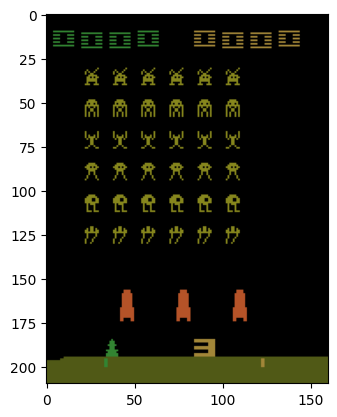

In [15]:
observation = env.reset()
for i in range(22):
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, reward, done, info = env.step(1)

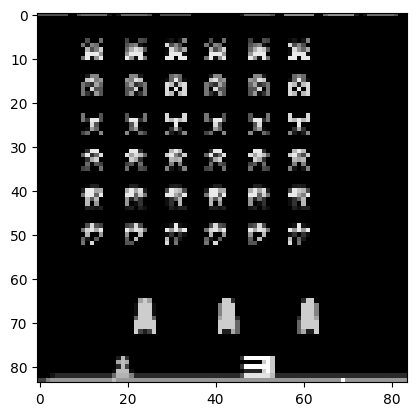

(210, 160, 3)
(84, 84)


In [16]:
# Mostrar las entradas preprocesadas en escala de grises y comparar originales y preprocesados.
processor = AtariProcessor()
obs_preprocessed = processor.process_observation(observation).reshape(INPUT_SHAPE)
# Seleccionamos el primer frame y lo normalizamos
frame = processor.process_state_batch(obs_preprocessed)
# Visualizar en escala de grises
plt.imshow(frame, cmap='gray')
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

#### Clase ReplayMemory

In [17]:
class ReplayMemory:
    """ReplayMemory optimizada para evitar fugas de memoria"""

    def __init__(self, capacity, state_shape):
        self.capacity = capacity
        self.position = 0
        self.size = 0

        # Pre-asignar arrays con el tamaño exacto
        # Usar uint8 para estados (más eficiente que float32)
        self.states = np.zeros((capacity, *state_shape), dtype=np.uint8)
        self.actions = np.zeros(capacity, dtype=np.int32)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.next_states = np.zeros((capacity, *state_shape), dtype=np.uint8)
        self.dones = np.zeros(capacity, dtype=np.bool_)

        print(f" [INFO] - ReplayMemory creada: {capacity} samples, {state_shape} shape")
        memory_size = (
            self.states.nbytes + self.next_states.nbytes +
            self.actions.nbytes + self.rewards.nbytes + self.dones.nbytes
        ) / (1024 * 1024)
        print(f" [INFO] - Memoria asignada: {memory_size:.2f} MB")

    def append(self, state, action, reward, next_state, done):
        """Añade una experiencia al buffer de forma eficiente"""
        # Convertir a uint8 para ahorrar memoria (estados son imágenes 0-255)
        if state.dtype != np.uint8:
            state = (state * 255).astype(np.uint8)
        if next_state.dtype != np.uint8:
            next_state = (next_state * 255).astype(np.uint8)

        # Almacenar directamente en el array pre-asignado
        self.states[self.position] = state
        self.actions[self.position] = action
        self.rewards[self.position] = reward
        self.next_states[self.position] = next_state
        self.dones[self.position] = done

        # Actualizar posición circular
        self.position = (self.position + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        """Muestra un batch de experiencias de forma eficiente"""
        if self.size < batch_size:
            raise ValueError(f"No hay suficientes samples ({self.size}) para batch_size ({batch_size})")

        # Generar índices aleatorios
        indices = np.random.choice(self.size, batch_size, replace=False)

        # Extraer batch y convertir de vuelta a float32 para el entrenamiento
        batch_states = self.states[indices].astype(np.float32) / 255.0
        batch_actions = self.actions[indices]
        batch_rewards = self.rewards[indices]
        batch_next_states = self.next_states[indices].astype(np.float32) / 255.0
        batch_dones = self.dones[indices]

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones

    def __len__(self):
        return self.size

    def clear(self):
        """Limpia la memoria de forma segura"""
        self.position = 0
        self.size = 0
        # No es necesario limpiar los arrays, se sobrescriben

#### Clase PerformanceMonitor

Actualmente no se usa, si se necesitase mayor detalle de la evolución de los entrenamientos se podría incluir en el Callback antes del entrenamiento. De momento no se usa!!!

In [18]:
# Clase para monitoreo de memoria y rendimiento
class PerformanceMonitor(tf.keras.callbacks.Callback):
    def __init__(self, save_path='diagnosticos'):
        self.save_path = save_path
        self.episode_times = []
        self.memory_usage = []
        self.current_episode = 0
        self.episode_start_time = None
        self.episode_start_memory = None

    def on_episode_begin(self, episode, logs={}):
        self.episode_start_time = time.time()
        self.episode_start_memory = psutil.Process().memory_info().rss / (1024 * 1024)
        self.current_episode = episode
        print(f" [INFO] - Episodio {episode} comenzando. Memoria inicial: {self.episode_start_memory:.2f} MB")

    def on_episode_end(self, episode, logs={}):
        end_time = time.time()
        final_memory = psutil.Process().memory_info().rss / (1024 * 1024)
        episode_duration = end_time - self.episode_start_time

        self.episode_times.append(episode_duration)
        self.memory_usage.append(final_memory)

        print(f" [INFO] - Episodio {episode} completado en {episode_duration:.2f} segundos")
        print(f" [INFO] - Memoria final: {final_memory:.2f} MB (cambio: {final_memory - self.episode_start_memory:.2f} MB)")

        # Guardar diagnóstico cada 5 episodios
        if (episode + 1) % 5 == 0:
            self.save_diagnostics(episode)

        # Forzar recolección de basura
        gc.collect()

    def save_diagnostics(self, episode):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.episode_times)
        plt.title('Tiempo por episodio')
        plt.ylabel('Segundos')
        plt.xlabel('Episodio')

        plt.subplot(1, 2, 2)
        plt.plot(self.memory_usage)
        plt.title('Uso de memoria')
        plt.ylabel('MB')
        plt.xlabel('Episodio')

        plt.tight_layout()
        plt.savefig(f"{self.save_path}/rendimiento_episodio_{episode+1}.png")
        plt.close()

### 1. Implementación de la red neuronal

#### Definición de las redes neuronales

Crearemos una clase para construir un red Q-profunda, con tres capas convolucionales, seguidas de una capa de aplanamiento y una capa completamente conectada.

In [19]:
def create_dqn_model(input_shape, nb_actions, memory_size):
    """
    Crea un modelo DQN usando SOLO Keras estándar. Base común para redes DQN y DDQN
    Red neuronal Deep Q-Network (DQN) para aproximar la función Q en aprendizaje por refuerzo.
    Construye un modelo que acepta channels_first y convierte internamente

    Esta función implementa una red convolucional que recibe un estado (conjunto de frames)
    y produce los valores Q para cada acción posible. Usa capas convolucionales seguidas
    de capas totalmente conectadas, con activación RELU.
    Esto evita completamente los problemas de grafos múltiples
    """
    print(f"🏗️ Creando modelo DQN estándar: input_shape={input_shape}, actions={nb_actions}")
       
    # Input en formato channels_first (como viene de SequentialMemory)
    inputs = Input(shape=SEQ_INPUT_SHAPE, name='input_channels_first')  # (4, 84, 84)

    # Convertir a channels_last usando Permute
    x = Permute((2, 3, 1), name='convert_to_channels_last')(inputs)  # (84, 84, 4)
    # Red convolucional estándar
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', padding='valid', name='conv1', input_shape=input_shape)(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', padding='valid', name='conv2')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='valid', name='conv3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='dense1')(x)
    outputs = Dense(nb_actions, activation='linear', name='q_values')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DQN_Model')
    memory = None
    
    print("✅ Modelo creado exitosamente")
    print(f"📊 Resumen del modelo:")
    model.summary()
    
    return model, memory, None

In [20]:
def create_ddqn_models(input_shape, nb_actions, memory_size):
    """
    Crea modelos para Double DQN (principal y objetivo)
    """
    print(f"🏗️ Creando modelos DDQN: input_shape={input_shape}, actions={nb_actions}")
    
    # Modelo principal
    main_model, _, _ = create_dqn_model(input_shape, nb_actions, memory_size)
    main_model._name = 'DDQN_Main_Model'    
    
    # Modelo objetivo (copia exacta)
    target_model = tf.keras.models.clone_model(main_model)
    target_model.set_weights(main_model.get_weights())
    target_model._name = 'DDQN_Target_Model'
    #Pequeño buffer para que entrene paso a paso
    memory = SequentialMemory(limit=10000, window_length=WINDOW_LENGTH)
    
    print("✅ Modelos DDQN creados exitosamente")    
    return main_model, memory, target_model

In [21]:
def create_ddqn_replay_model(input_shape, nb_actions, memory_size):
    print(f"🏗️ Creando modelos DDQN_replay: input_shape={input_shape}, actions={nb_actions}")
    
    # Input en formato channels_first (como viene de SequentialMemory)
    inputs = Input(shape=SEQ_INPUT_SHAPE, name='input_channels_first')  # (4, 84, 84)

    # Convertir a channels_last usando Permute
    x = Permute((2, 3, 1), name='convert_to_channels_last')(inputs)  # (84, 84, 4)
    # Red convolucional estándar
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', padding='valid', name='conv1', input_shape=input_shape)(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', padding='valid', name='conv2')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='valid', name='conv3')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='dense1')(x)
    outputs = Dense(nb_actions, activation='linear', name='q_values')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='DDQN_replay_Main_Model')
    memory = SequentialMemory(limit=memory_size, window_length=WINDOW_LENGTH)
    target_model = clone_model(model)  # Create target model for DDQN
    target_model.set_weights(model.get_weights())  # Initialize with same weights
    target_model._name = 'DDQN_replay_Target_Model'    
    
    print("✅ Modelo creado exitosamente")
    print(f"📊 Resumen del modelo:")
    model.summary()
    return model, memory, target_model

In [22]:
def create_dueling_dqn_replay_model(input_shape, action_size, memory_size):
    """
    Crea un modelo Dueling DQN con replay.
    """
    print(f"🏗️ Creando modelo DUELING_DQN_REPLAY: input_shape={input_shape}, actions={action_size}")
    # Input en formato channels_first (como viene de SequentialMemory)
    inputs = Input(shape=SEQ_INPUT_SHAPE, name='input_channels_first')  # (4, 84, 84)    
    x = Permute((2, 3, 1))(inputs)
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu', padding='valid', input_shape=input_shape)(x)
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu', padding='valid')(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu', padding='valid')(x)
    x = Flatten()(x)
    # Value stream
    value = Dense(512, activation='relu')(x)
    value = Dense(1, activation='linear')(value)
    # Advantage stream
    advantage = Dense(512, activation='relu')(x)
    advantage = Dense(action_size, activation='linear')(advantage)
    # Combine streams
    outputs = Add()([value, Lambda(lambda a: a - K.mean(a, axis=1, keepdims=True))(advantage)])
    model = Model(inputs=inputs, outputs=outputs, name='DuelingDQNReplay_Main_Model')
    memory = SequentialMemory(limit=memory_size, window_length=WINDOW_LENGTH)   
    target_model = clone_model(model)
    target_model.set_weights(model.get_weights())    
    target_model._name = 'DuelingDQNReplay_Target_Model'     
   
    print("✅ Modelo creado exitosamente")
    print(f"📊 Resumen del modelo:")
    model.summary()
    return model, memory, target_model

### 2. Implementación de la solución DQN

#### Funciones auxiliares

In [23]:
def load_model_checkpoint(model, memory, target_model, model_name, checkpoint_dir="checkpoints", suffix="lastest"):
    """
    Carga pesos y estado para componentes separados (modelo, memoria, target_model).
    
    Parámetros:
    -----------
        model: El modelo principal
        memory: La memoria de repetición
        target_model: El modelo target (puede ser None)
        model_name: Tipo del modelo ('DDQN_REPLAY', 'DUELING_DQN_REPLAY', etc.)
        checkpoint_dir: Directorio donde buscar los checkpoints
        suffix: Tipo de checkpoint a cargar ("lastest", "best", o "epXXX")

    Retorna:
    --------
        tuple: (episode, steps, epsilon) - El episodio, pasos y epsilon desde donde continuar
               Si no se encuentra el checkpoint, devuelve (0, 0, 0.1)
    """  
    # Valores predeterminados
    episode = 0
    steps = 0
    epsilon = 0.1  # Valor por defecto
    
    # Definir las rutas de los archivos
    main_model_path = f"{checkpoint_dir}/{model_name}_{suffix}_model.h5"
    target_model_path = f"{checkpoint_dir}/{model_name}_{suffix}_target.h5"
    memory_path = f"{checkpoint_dir}/{model_name}_{suffix}_memory.pkl"
    state_path = f"{checkpoint_dir}/{model_name}_{suffix}_state.json"    
      
    try:    
        # Cargar estado del entrenamiento
        if not os.path.exists(state_path):
            print(f"⚠️ No se encontró el checkpoint {suffix} para {model_name}")
            return episode, steps, epsilon 
        else:
            print(f"📂 Se cargó: {state_path}")        

        with open(state_path, 'r') as f:
            state = json.load(f)
            
        # Extraer información básica
        episode = state.get('episode', 0)
        steps = state.get('global_steps', 0)
        epsilon = state.get('epsilon', 0.1)
        
        print(f"📂 Cargando checkpoint {suffix} (episodio: {episode}, pasos: {steps}, epsilon: {epsilon})")
        
    except Exception as e:
        print(f"⚠️ Error al cargar el archivo de estado: {e}")
        
    # Cargar modelo principal
    if os.path.exists(main_model_path):
        try:
            model.load_weights(main_model_path)
            print(f"📂 Modelo principal cargado: {main_model_path}")
        except Exception as e:
            print(f"❌ [ERROR] - Error al cargar el modelo principal: {e}")
            return 0, 0, 0.1  # Si falla la carga del modelo principal, mejor empezar desde cero
    else:
        print(f"❌ [ERROR] - No se encontró el archivo del modelo principal: {main_model_path}")
        return 0, 0, 0.1       

    # Cargar modelo target si existe y se proporcionó
    if target_model is not None:
        if os.path.exists(target_model_path):
            try:
                target_model.load_weights(target_model_path)
                print(f"📂 Modelo target cargado: {target_model_path}")
            except Exception as e:
                print(f"⚠️ [WARNING] - Error al cargar el modelo target: {e}")
                # Si hay error, sincronizar con el principal
                print("🔄 Sincronizando red target desde la principal...")
                target_model.set_weights(model.get_weights())
        else:
            # Si no existe el archivo, sincronizar con el principal
            print("🔄 No se encontró archivo target, sincronizando desde la principal...")
            target_model.set_weights(model.get_weights())
          
    # Cargar memoria si corresponde al tipo de modelo
    if model_name in ['DDQN_REPLAY', 'DUELING_DQN_REPLAY'] and memory is not None and os.path.exists(memory_path):
        try:              
            with open(memory_path, 'rb') as f:
                loaded_memory = pickle.load(f)                
                
            # Transferir contenido no reemplazar objeto
            memory_loaded = False
            # Estructura SequentialMemory (Keras-RL)
            if hasattr(loaded_memory, 'observations') and hasattr(memory, 'observations'):
                memory.observations = loaded_memory.observations
                memory.actions = loaded_memory.actions
                memory.rewards = loaded_memory.rewards
                memory.terminals = loaded_memory.terminals
                if hasattr(loaded_memory, 'observations_'):
                    memory.observations_ = loaded_memory.observations_
                memory_loaded = True
            elif hasattr(loaded_memory, 'buffer') and hasattr(memory, 'buffer'):
                memory.buffer = loaded_memory.buffer
                memory.position = loaded_memory.position
                if hasattr(loaded_memory, 'size'):
                    memory.size = loaded_memory.size
                memory_loaded = True

            if memory_loaded:
                print(f"📂 Memoria cargada correctamente: {memory_path}")
            else:
                print(f"⚠️ Estructura de memoria desconocida, no se pudo cargar")

        except Exception as e:
            print(f"⚠️ Error al cargar la memoria: {e}")    
    
    return episode, steps, epsilon

In [24]:
# Función auxiliar para convertir objetos no serializables a JSON
def convert_to_json_serializable(obj):
    """Convierte tipos numpy a tipos Python nativos para serialización JSON"""
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (datetime.datetime, datetime.date)):
        return obj.isoformat()
    else:
        # Para cualquier otro tipo no reconocido
        return str(obj)

In [25]:
def save_model_checkpoint(agent, model_name, episode=0, steps=0, 
                          checkpoint_dir="checkpoints", suffix="lastest", epsilon=0.1):
    """           
    Guarda el modelo, la memoria de repetición y el estado del entrenamiento.
    
    Esta función guarda los pesos de un modelo de red neuronal en un archivo HDF5 (.h5) y, para modelos con memoria
    de repetición (como DDQNetworkWithReplay o DuelingDQNetworkWithReplay), guarda la memoria en un archivo pickle (.pkl).
    Los archivos se nombran usando un prefijo basado en la clase del modelo y el número de episodio, siguiendo el formato
    `{prefijo}_checkpoint_ep{episode}.h5` para pesos y `{prefijo}_memory_ep{episode}.pkl` para memoria.    

    Parámetros:
    -----------
        model: El modelo principal
        memory: La memoria de repetición
        target_model: El modelo target (puede ser None)
        model_name: Nombre base del modelo (ej: 'DQN', 'DDQN_REPLAY')
        episode: Número del episodio actual
        steps: Pasos globales acumulados
        checkpoint_dir: Directorio donde guardar los checkpoints
        suffix: Tipo de checkpoint ("lastest", "best", o "epXXX")
        
        model : tensorflow.keras.Model-  El modelo principal de red neuronal que se desea guardar.
        memory : objeto de memoria-      La memoria de repetición utilizada para almacenar experiencias de entrenamiento.
                                         Puede ser SequentialMemory, ReplayBuffer u otra implementación compatible.
        target_model : tensorflow.keras.Model-         El modelo target utilizado en algoritmos como DDQN. Es una copia del modelo principal
            que se actualiza periódicamente durante el entrenamiento.
        model_name : str-                Nombre identificativo del modelo ('DQN', 'DDQN', 'DDQN_REPLAY', 'DUELING_DQN_REPLAY', etc.).
                                         Se utiliza para nombrar los archivos de checkpoint.
        episode : int, opcional-         Número del episodio actual de entrenamiento. Por defecto es 0.
        steps : int, opcional-           Número total de pasos (interacciones con el entorno) realizados. Por defecto es 0.

        checkpoint_dir : str, opcional-  Directorio donde se guardarán los archivos de checkpoint. Por defecto es "checkpoints".

        suffix : str, opcional-          Sufijo para identificar el tipo de checkpoint ("lastest", "best", o "epXXX"). Por defecto es "lastest".

        epsilon : float, opcional-       Valor actual de epsilon para la política epsilon-greedy. Por defecto es 0.1.
        force_override: Si es True, sobrescribe incluso los checkpoints 'best'    

    Retorna:
    --------
        None
    """   
    # Asegurar que existe el directorio
    os.makedirs(checkpoint_dir, exist_ok=True)
    # Puedes intentar limpiar la memoria de Python no usada explícitamente antes de medir
    gc.collect()     
    
    # Definir las rutas de los archivos
    main_model_path = f"{checkpoint_dir}/{model_name}_{suffix}_model.h5"
    target_model_path = f"{checkpoint_dir}/{model_name}_{suffix}_target.h5"
    memory_path = f"{checkpoint_dir}/{model_name}_{suffix}_memory.pkl"
    state_path = f"{checkpoint_dir}/{model_name}_{suffix}_state.json"    
    
    # PROTECCIÓN DE CHECKPOINTS EXISTENTES
    # Si es un checkpoint "best" y estamos intentando guardarlo con episodio 0
    if ("best" in suffix or "lastest" in suffix) and episode == 0:
        # Verificar si ya existe un mejor checkpoint con episodio > 0
        state_path = f"{checkpoint_dir}/{model_name}_best_state.json"
        if os.path.exists(state_path):
            try:
                with open(state_path, 'r') as f:
                    existing_state = json.load(f)
                existing_episode = existing_state.get('episode', 0)
                
                if existing_episode > 0:
                    print(f"🛡️ Protegiendo checkpoint '{suffix}' existente (ep: {existing_episode})")
                    print(f"❌ NO se guardará un nuevo checkpoint con episodio 0")
                    return
            except Exception as e:
                print(f"⚠️ Error verificando checkpoint existente: {e}")

    try:
        # Guardar pesos del modelo principal
        if hasattr(agent, 'model'):
            agent.model.save_weights(main_model_path)
            print(f"💾 Guardado modelo principal {suffix}: {main_model_path}")               
        else:
            print(f"⚠️ El agente no tiene el atributo 'model'")          
        
        # Guardar pesos del modelo target si existe
        if hasattr(agent, 'target_model') and agent.target_model is not None:
            agent.target_model.save_weights(target_model_path)      
            print(f"💾 Guardado modelo target {suffix}: {target_model_path}")         
        else:
            print(f"⚠️ El agente no tiene el atributo 'target_model' o es None")            

        # Preparar el estado del entrenamiento - Con conversión a tipos Python nativos
        state = {
            'episode': int(episode),  
            'global_steps': int(steps),  
            'epsilon': float(epsilon),        
            'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }              
        
        # Si hay una política específica en el agente
        if hasattr(agent, 'policy'):
            policy_state = {}
            
            # Intentar guardar el estado de la política
            if hasattr(agent.policy, 'eps'):
                policy_state['eps'] = float(agent.policy.eps)  # Convertir a float Python
        
            # Si la política tiene más atributos relevantes
            for attr in ['value_max', 'value_min', 'value_test', 'nb_steps']:
                if hasattr(agent.policy, attr):
                    value = getattr(agent.policy, attr)
                    if isinstance(value, (np.integer, np.floating, np.bool_)):
                        value = value.item()  # Convierte cualquier tipo numpy a su equivalente Python
                    policy_state[attr] = value
            
            if policy_state:
                state['policy'] = policy_state                  
               
        # Guardar memoria de repetición para modelos con replay
        if model_name in ['DDQN_REPLAY', 'DUELING_DQN_REPLAY'] and hasattr(agent, 'memory') and agent.memory is not None:
            try:
                # Usar compresión máxima
                with open(memory_path, 'wb') as f:
                    pickle.dump(agent.memory, f)
                print(f"💾 Memoria {suffix} guardada: {memory_path}")  
            except Exception as e:
                print(f"⚠️ No se pudo guardar la memoria: {e}")       
        
        # Guardar el estado
        with open(state_path, 'w') as f:
            json.dump(state, f, indent=2, default=convert_to_json_serializable)
        
        print(f"💾 Checkpoint {suffix} guardado (ep: {episode}, pasos: {steps})")  
    
    except Exception as e:
        print(f"⚠️ Error guardando checkpoint {suffix}: {e}")

    return

In [26]:
class SimpleProgressCallback(tf.keras.callbacks.Callback):
    """
    Callback personalizado para monitorear el progreso del entrenamiento de un agente DQN.

    Registra el avance en términos de pasos completados, porcentaje, velocidad de entrenamiento
    (pasos por segundo) y tiempo estimado de finalización (ETA).

    Atributos:
        total_steps (int): Número total de pasos de entrenamiento.
        print_interval (int): Intervalo de pasos para imprimir el progreso (por defecto: 10,000).
        start_time (float): Tiempo de inicio del entrenamiento (en segundos).
        last_step (int): Último paso registrado (inicializado en 0).
    """
    def __init__(self, total_steps, print_interval=100):
        """
        Inicializa el callback.

        Args:
            total_steps (int): Número total de pasos de entrenamiento.
            print_interval (int): Intervalo de pasos para imprimir el progreso.
        """
        super().__init__()
        self.total_steps = total_steps
        self.print_interval = print_interval
        self.step_counter = 0
        self.start_time = time.time()
        self.episode_rewards = []  # Store clipped episode rewards
        self.episode_steps = []
        self.current_episode_reward = 0.0  # Track clipped reward for current episode

    def on_train_begin(self, logs={}):
        """
        Se ejecuta al inicio del entrenamiento.

        Inicializa el tiempo de inicio y muestra un mensaje de comienzo.

        Args:
            logs (dict): Diccionario de métricas (no utilizado aquí).
        """
        self.start_time = time.time()
        print(f"🚀 Entrenamiento iniciado: {self.total_steps:,} pasos")

    def on_step_end(self, step, logs={}):
        """
        Se ejecuta al final de cada paso de entrenamiento.

        Calcula y muestra el progreso, incluyendo porcentaje completado, velocidad
        (pasos por segundo) y tiempo estimado de finalización (ETA) en horas.

        Args:
            step (int): Número del paso actual.
            logs (dict): Diccionario de métricas (no utilizado aquí).
        """
        self.step_counter += 1        
        raw_reward = logs.get('reward', 0.0)
        clipped_reward = np.clip(raw_reward, -1.0, 1.0)  # Match AtariProcessor clipping
        self.current_episode_reward += clipped_reward
        if self.step_counter % self.print_interval == 0:
            progress = (self.step_counter / self.total_steps) * 100
            elapsed_time = (time.time() - self.start_time)
            steps_per_sec = self.step_counter / elapsed_time
            eta_hours = (self.total_steps - self.step_counter) / steps_per_sec / 3600
            memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)
            print(f"📊 Paso {self.step_counter:,}/{self.total_steps:,} ({progress:.1f}%) - "
                  f"{steps_per_sec:.1f} pasos/seg - ETA: {eta_hours:.1f}h - Memoria: {memory_usage:.2f} MB")
    
    def on_episode_end(self, episode, logs={}):
        nb_steps = logs.get('nb_episode_steps', 1)
        self.episode_rewards.append(self.current_episode_reward)
        self.episode_steps.append(nb_steps)
        mean_reward = self.current_episode_reward / nb_steps if nb_steps > 0 else 0
        print(f"📈 Episodio {episode+1}: Recompensa total (clipped): {self.current_episode_reward:.3f}, "
              f"Pasos: {nb_steps}, Mean Reward Calculado: {mean_reward:.6f} (Recompensa/Pasos)")
        # Reset for next episode
        self.current_episode_reward = 0.0            
            

In [27]:
class TargetRewardTracker(tf.keras.callbacks.Callback):
    """
    Callback que monitorea el progreso hacia una media de episode_reward objetivo
    e integra con nuestro sistema de checkpoints.
    """      
    def __init__(self, dqn, target_avg_reward=20.0, name_model=None, window_size=100, save_best=True, checkpoint_dir=checkpoint_path):
        super().__init__()
        self.target_avg_reward = target_avg_reward
        self.window_size = window_size
        self.save_best = save_best
        # Obtener el nombre del modelo sin ruta
        self.model = dqn
        self.model_name = name_model
        self.episode_count = 0
        self.episode_rewards = []
        self.best_avg_reward = float('-inf')
        self.episodes_at_target = 0
        self.consecutive_target_episodes = 0
        self.checkpoint_dir =  f"{checkpoint_path}/{self.model_name}"
        os.makedirs(self.checkpoint_dir, exist_ok=True)       
        
        print(f"🎯 OBJETIVO: Media de episode_reward = {target_avg_reward}")
        print(f"📊 Ventana de evaluación: {window_size} episodios")        

    def on_episode_end(self, episode, logs=None):
        logs = logs or {}
        # Forzar recolección de basura
        gc.collect()        
        
        self.episode_count += 1
        episode_reward = logs.get('episode_reward', 0)
        # Convert NumPy types to Python types
        if isinstance(episode_reward, np.floating):
            episode_reward = episode_reward.item()
        self.episode_rewards.append(episode_reward)
        
        # Calcular media móvil
        if len(self.episode_rewards) >= self.window_size or self.episode_count % 10 == 0:
            recent_rewards = self.episode_rewards[-self.window_size:]
            current_avg = np.mean(recent_rewards)
            
            # Verificar si alcanzamos el objetivo
            target_reached = current_avg >= self.target_avg_reward
            
            if target_reached:
                self.episodes_at_target += 1
                self.consecutive_target_episodes += 1
            else:
                self.consecutive_target_episodes = 0
            
            # Guardar si es el mejor promedio
            if current_avg > self.best_avg_reward or self.episode_count % 10 == 0:
                self.best_avg_reward = current_avg
                if self.save_best and hasattr(self, 'model') and self.episode_count % 50 == 0:
                    # Formato del sufijo para el mejor modelo con su promedio
                    best_suffix = f"best_avg{current_avg:.1f}"                               
                    try:
                        epsilon = self.model.policy.eps if hasattr(self.model, 'policy') and hasattr(self.model.policy, 'eps') else 0.1
                       
                        # Usar nuestro sistema de checkpoint para guardar el mejor modelo
                        if hasattr(self.model, 'model'): # Por si el agente es un DQNAgent con un .model
# AVG                            save_model_checkpoint(   self.model,   self.model_name,
# AVG                                episode=self.episode_count,     steps=getattr(self.model, 'step', 0),
# AVG                                checkpoint_dir=self.checkpoint_dir,   suffix=best_suffix, 
# AVG                                epsilon=epsilon
# AVG                            )                                             
                            # También actualizar el checkpoint "best" general
                            save_model_checkpoint(   self.model,    self.model_name,
                                episode=self.episode_count,     steps=getattr(self.model, 'step', 0),
                                checkpoint_dir=self.checkpoint_dir,   suffix="best", 
                                epsilon=epsilon
                            )
                        else:
                            # Si no es un agente completo, guardar solo los pesos
                            best_filename = f"{self.checkpoint_dir}/{self.model_name}_{best_suffix}_model.h5"
                            self.model.save_weights(best_filename, overwrite=True)                        
                            
                        # Guardar métricas en JSON
                        metrics = {
                            "episode": int(self.episode_count),
                            "avg_reward": float(current_avg),
                            "best_avg_reward": float(self.best_avg_reward),
                            "timestamp": int(time.time()),
                            "consecutive_target_episodes": int(self.consecutive_target_episodes),
                            "episodes_at_target": int(self.episodes_at_target)
                        }
                        metrics_file = f"{self.checkpoint_dir}/{self.model_name}_{best_suffix}_metrics.json"
                        with open(metrics_file, 'w') as f:
                            json.dump(metrics, f, indent=2, default=str)
                        
                        print(f"💾 NUEVO MEJOR PROMEDIO: {current_avg:.2f} - Guardado en {self.checkpoint_dir}")
                    except Exception as e:
                        print(f"⚠️ [ERROR] - Error guardando mejor modelo: {e}")
            
            # Mostrar progreso cada 50 episodios
            if self.episode_count % 50 == 0:
                progress_pct = (current_avg / self.target_avg_reward) * 100
                target_status = "🎯 OBJETIVO ALCANZADO!" if target_reached else f"📈 {progress_pct:.1f}% del objetivo"
                
                print(f"\n📊 EPISODIO {self.episode_count} - PROGRESO HACIA OBJETIVO")
                print(f"   Reward actual: {episode_reward:.2f}")
                print(f"   Media últimos {self.window_size}: {current_avg:.2f} / {self.target_avg_reward}")
                print(f"   Mejor promedio histórico: {self.best_avg_reward:.2f}")
                print(f"   Estado: {target_status}")
                print(f"   Episodios en objetivo: {self.episodes_at_target}")
                print(f"   Episodios consecutivos en objetivo: {self.consecutive_target_episodes}")
                
                if self.consecutive_target_episodes >= 50:
                    print(f"🏆 ¡MODELO ESTABLE EN OBJETIVO! {self.consecutive_target_episodes} episodios consecutivos")
    
    def on_train_end(self, logs=None):
        """Resumen final del entrenamiento"""
        logs = logs or {}
        if len(self.episode_rewards) >= self.window_size:
            final_avg = np.mean(self.episode_rewards[-self.window_size:])
            objetivo_alcanzado = final_avg >= self.target_avg_reward
            
            print(f"\n🏁 RESUMEN FINAL DEL ENTRENAMIENTO")
            print(f"   Total episodios: {self.episode_count}")
            print(f"   Media final últimos {self.window_size}: {final_avg:.2f}")
            print(f"   Objetivo ({self.target_avg_reward}): {'✅ ALCANZADO' if objetivo_alcanzado else '❌ NO ALCANZADO'}")
            print(f"   Mejor promedio histórico: {self.best_avg_reward:.2f}")
            print(f"   Episodios que alcanzaron objetivo: {self.episodes_at_target}")
            
            # Save final metrics to JSON
            final_metrics = {
                "total_episodes": int(self.episode_count),
                "final_avg_reward": float(final_avg),
                "target_reached": bool(objetivo_alcanzado),
                "best_avg_reward": float(self.best_avg_reward),
                "episodes_at_target": int(self.episodes_at_target),
                "consecutive_target_episodes": int(self.consecutive_target_episodes)  
            }
            final_log_path = f"{self.checkpoint_dir}/final_metrics.json"
            try:
                with open(final_log_path, 'w') as f:
                    json.dump(final_metrics, f, indent=2, default=str)                                    
                print(f"💾 Métricas finales guardadas en: {final_log_path}")
            except Exception as e:
                print(f"⚠️ Error al guardar métricas finales: {e}")           

In [28]:
class CustomFileLogger(FileLogger):
    def __init__(self, filepath, interval=100):
        super().__init__(filepath, interval)
        self.step = 0  
        self.filepath = filepath
        self.interval = interval
        self.current_episode_reward = 0.0
        self.logs = {}        
    
    def on_step_end(self, step, logs={}):
        self.step += 1  
        if self.step % self.interval == 0:
            episode_logs = {}
        raw_reward = logs.get('reward', 0.0)
        self.current_episode_reward += np.clip(raw_reward, -1.0, 1.0)

    def on_episode_end(self, episode, logs):
        metrics = logs.copy()
        metrics['episode_reward'] = self.current_episode_reward
        metrics['mean_reward_step'] = self.current_episode_reward / metrics.get('nb_episode_steps', 1)
        metrics = {k: float(v) if isinstance(v, np.floating) else v for k, v in metrics.items()}
        self.metrics[int(episode)] = metrics
        if self.step % self.interval == 0:
            with open(self.filepath, 'w') as f:
                json.dump(self.metrics, f, indent=2, default=str)                
        self.current_episode_reward = 0.0

In [29]:
class EpisodeCheckpointCallback(tf.keras.callbacks.Callback):
    """
    Callback para guardar checkpoints episódicamente usando nuestras funciones personalizadas.
    """    
    def __init__(self, dqnet, checkpoint_path, save_freq=100, model_name='DQN'):
        """
        Inicializa el callback.
        
        Parametros:
            dqnet: El agente DQN a guardar
            checkpoint_path: Ruta donde guardar los checkpoints
            save_freq: Frecuencia de episodios para guardar
            model_name: Nombre base para los archivos de checkpoint
        """        
        super().__init__()
        self.save_freq = save_freq
        self.model_name = model_name
        self.checkpoint_path = f"{checkpoint_path}/{self.model_name}"
        self.episode_counter = 0
        self.dqnet = dqnet
        os.makedirs(checkpoint_path, exist_ok=True)
    
    def on_episode_end(self, episode, logs={}):
        """
        Guarda checkpoint al final de ciertos episodios.
        """        
        self.episode_counter += 1
        if self.episode_counter % self.save_freq == 0:
            try:       
                epsilon = self.dqnet.policy.eps if hasattr(self.dqnet, 'policy') and hasattr(self.dqnet.policy, 'eps') else 0.1
                # También actualizar el checkpoint "lastest"
                save_model_checkpoint(
                    self.dqnet, 
                    self.model_name,
                    episode=self.episode_counter,
                    steps=self.dqnet.step, 
                    checkpoint_dir=self.checkpoint_path, 
                    suffix="lastest",
                    epsilon=epsilon
                )                
                print(f"✅ Checkpoint guardado para episodio {self.episode_counter}")        
                        
            except Exception as e:
                print(f"❌ [ERROR] - Error al guardar checkpoint para episodio {self.episode_counter}: {str(e)}")              

#### **ENTRENAMIENTO** ***********

In [30]:
def entrenar_modelo(env,  model_name,  model, memory, target_model, model_instance=False, 
        start_episode=0, start_steps=0,
        batch_size=batch_size, learning_rate=learning_rate, checkpoint_path='checkpoints',
        input_shape=MODEL_INPUT_SHAPE, memoria_tamano=memory_size, warmup_steps=WARMUP_STEPS,
        target_update_interval=TARGET_UPDATE_INTERVAL, target_update_tau=tau, epsilon_start=epsilon_start,
        epsilon_min=0.1, epsilon_steps=EPSILON_STEPS, num_steps=NUM_TRAINING_STEPS, target_reward=TARGET_REWARD,
        enable_double_dqn = False):     
    """
    Entrena un modelo DQN con el entorno proporcionado
    
    Parámetros:
    -----------
        env: El entorno de Gym
        model_name: Nombre identificador del modelo ('DQN', 'DDQN', etc.)
        model: El modelo principal
        memory: La memoria de repetición
        target_model: El modelo target (puede ser None para DQN)        
        model_instance: Flag que determina si existe modelo cargado (si False, se crea uno nuevo)
        checkpoint_path: Ruta donde guardar checkpoints
        start_episode: Episodio desde donde continuar el entrenamiento
        start_steps: Pasos desde donde continuar el entrenamiento
        batch_size: Tamaño del lote para el entrenamiento
        learning_rate: Tasa de aprendizaje del optimizador
        input_shape: Forma de la entrada para el modelo
        memoria_tamano: Tamaño de la memoria de repetición
        warmup_steps: Pasos de calentamiento antes del entrenamiento
        target_update_interval: Intervalo para actualizar la red objetivo
        target_update_tau: Factor de actualización suave para la red objetivo
        epsilon_start: Valor inicial de epsilon para exploración
        epsilon_min: Valor mínimo de epsilon para exploración
        epsilon_steps: Número de pasos para decrementar epsilon
        num_steps: Número total de pasos de entrenamiento
        target_reward: Recompensa objetivo para considerar resuelto el entorno
        enable_double_dqn: Si es True, usa DDQN; si no, usa DQN estándar
        
    Retorna:
    --------
        tuple: (agente_entrenado, éxito) - Modelo entrenado y booleano indicando éxito    
    """
    # Nombre del modelo para logs y checkpoints
    name_model = model_name.upper()    
    print(f"🤖 {'Continuando' if model_instance else 'Creando'} entrenamiento para {name_model}...")
        
    # Inicializar dqn desde el principio para evitar referencia antes de asignación
    dqn = None      
    save_checkpoint_path = f"{checkpoint_path}/{model_name}"
    # Inicializar callbacks al principio para asegurarnos de que siempre esté definido
    callbacks = []
    # Verificar target_model solo si estamos usando DDQN
    if enable_double_dqn and target_model is None:
        raise ValueError("Para DDQN, el target_model no puede ser None.")
            
    # Crear el procesador Atari
    processor = AtariProcessor()   
    try:  
        # Verificar que tenemos un modelo válido
        if model is None:
            raise ValueError("El modelo principal no puede ser None.")              
        # Verificar target_model solo si estamos usando DDQN
        if enable_double_dqn and target_model is None:
            raise ValueError("Para DDQN, el target_model no puede ser None.")

        # Verificar si la memoria ya se creó o necesitamos crearla
        if memory is None:
             memory = SequentialMemory(limit=memory_size, window_length=WINDOW_LENGTH)
         # Para DDQN ejecutar paso a paso, así vermos diferencia con DDQN_REPLAY
        if model_name in ['DDQN']:
            train_interval_param = 1
            warmup_steps_param = 0
        else:
            train_interval_param = WINDOW_LENGTH
            warmup_steps_param = warmup_steps
        
        # Política de exploración
        policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                                     attr='eps',
                                     value_max=epsilon_start, 
                                     value_min=epsilon_min, 
                                     value_test=.05,
                                     nb_steps=epsilon_steps)  
        # Crear agente DQN
        dqn = DQNAgent(
            model=model,
            nb_actions=env.action_space.n,
            memory=memory,
            processor=processor,
            nb_steps_warmup=warmup_steps_param,
            target_model_update=target_update_interval if enable_double_dqn else 10000,
            enable_double_dqn=enable_double_dqn,
            policy=policy,
            gamma=0.99,
            train_interval=train_interval_param,
            delta_clip=1.0,
            batch_size=batch_size
        )                
        # Después de crear el agente, reemplazar el target_model si estamos usando DDQN
        if enable_double_dqn and target_model is not None:
            dqn.target_model = target_model            

        # Compilar el agente
        optimizer = Adam(learning_rate=learning_rate)  
        dqn.compile(optimizer=optimizer, metrics=['mae'])

    except Exception as e:
        print(f"❌ Error al crear o compilar el agente: {str(e)}")
        return None, False
        
    # Verificar que tenemos un agente válido antes de continuar
    if dqn is None:
        print(f"❌ Error: No se pudo inicializar el agente DQN")
        return None, False        
    try:
        # DEBUG --------------------
        # callbacks = [
        #     log_filename = f'{checkpoint_path}/{name_model}_log.json'
        #     progress_callback,
        #     ModelIntervalCheckpoint(checkpoint_weights_filename, interval=250000),
        #     CustomFileLogger(log_filename, interval=1000),
        #     PerformanceMonitor(save_path='diagnosticos')
        # ]
        # Callbacks optimizados para el objetivo
        callbacks = [
            SimpleProgressCallback(num_steps, print_interval=20000),         
            TargetRewardTracker(dqn,target_avg_reward=target_reward, name_model=name_model, window_size=100, 
                                save_best=True, checkpoint_dir=checkpoint_path),
            EpisodeCheckpointCallback(dqn, checkpoint_path=checkpoint_path, save_freq=1000, model_name=name_model)    
        ]         
          
         # Ajustar el número de pasos restantes si estamos continuando el entrenamiento
        adjusted_steps = max(0, num_steps - start_steps)
        if start_steps > 0:
            print(f"Continuando desde el paso {start_steps} (quedan {adjusted_steps} pasos)")

        print(f"Iniciando entrenamiento de {name_model} por {adjusted_steps} pasos...")
        start_time = time.time()       
        # Fit del agente al entorno
        history = dqn.fit(env, nb_steps=adjusted_steps, callbacks=callbacks, verbose=2)
       
        training_time = (time.time() - start_time) / 60
        print(f"Entrenamiento completado en {training_time:.2f} minutos")
        
        # Guardar checkpoint final
        # Verificar correctamente las claves disponibles y usar la adecuada
        if hasattr(history, 'history'):
            if 'episode' in history.history and history.history['episode']:
                episode = start_episode + history.history['episode'][-1]
            elif 'nb_episode' in history.history and history.history['nb_episode']:
                episode = start_episode + history.history['nb_episode'][-1]
            else:
                # Intentar obtener el episodio del agente directamente
                episode = getattr(dqn, 'episode', start_episode)
        else:
            episode = start_episode        
        steps = start_steps + adjusted_steps
        epsilon = dqn.policy.eps if hasattr(dqn, 'policy') and hasattr(dqn.policy, 'eps') else 0.1          
        try:
            save_model_checkpoint(dqn, name_model, episode=episode, steps=steps,
                                checkpoint_dir=save_checkpoint_path, suffix="lastest", 
                                epsilon=epsilon)
                
            # También guardar como "best" si no hay un checkpoint "best" previo
            save_model_checkpoint(dqn, name_model, episode=episode, steps=steps,
                                    checkpoint_dir=save_checkpoint_path, suffix="best", 
                                    epsilon=epsilon)
        except Exception as e:
            print(f"⚠️ Error al guardar el modelo: {str(e)}")
                                                        
        return dqn, True    
    
    except KeyboardInterrupt:
        print("\nEntrenamiento interrumpido por el usuario") 
        # Guardar pesos de emergencia
        try:
            epsilon = dqn.policy.eps if hasattr(dqn, 'policy') and hasattr(dqn.policy, 'eps') else 0.1
            episode = start_episode  # No podemos saber el episodio exacto después de la interrupción
            steps = start_steps + dqn.step if hasattr(dqn, 'step') else start_steps
            save_model_checkpoint(dqn, name_model, episode=episode, steps=steps,
                                checkpoint_dir=save_checkpoint_path, suffix="emergency", 
                                epsilon=epsilon)
            print("✅ Modelo guardado en estado de emergencia")
        except Exception as e:
            print(f"⚠️ Error al guardar el modelo de emergencia: {str(e)}")
        return dqn, True
        
    except Exception as e:
        print(f"\n❌ [ERROR] - Error durante el entrenamiento: {str(e)}")
        # Intentar guardar en estado de error
        try:
            epsilon = dqn.policy.eps if hasattr(dqn, 'policy') and hasattr(dqn.policy, 'eps') else 0.1
            save_model_checkpoint(dqn, name_model, episode=start_episode, 
                                steps=start_steps + (dqn.step if hasattr(dqn, 'step') else 0),
                                checkpoint_dir=save_checkpoint_path, suffix="error_recovery", 
                                epsilon=epsilon)
            print("✅ Modelo guardado en estado de recuperación de error")
        except Exception as e2:
            print(f"⚠️ Error al guardar modelo de recuperación: {str(e2)}")
        return None, False

#### **EVALUACION** ***********

In [31]:
# Función para evaluar el modelo
def evaluar_modelo(agent, model_name, env, num_episodes=200, render=True, record_video=False):
    """
    Evalúa un modelo DQN o DDQN y si el modelo alcanza el objetivo de media

    Parámetros:
    -----------
        agent: Agente DQN entrenado
        model_name: Nobre del agente
        env: Entorno de gym
        num_episodes: Número de episodios para evaluar
        render: Si se debe mostrar la visualización
        record_video: Si se debe grabar video

    Retorna:
    --------
        Lista de recompensas por episodio
    """
    print(f"🎯 EVALUANDO MODELO {model_name}")
    print(f"📊 Evaluando por {num_episodes} episodios...")
    rewards = []
    rewards_clip = []    
    
    # Setup for frame stacking
    window_length = 4  # As specified in your model input shape
    
    try:
        for episode in range(num_episodes):
            # Reset environment
            observation = env.reset()
            done = False
            total_reward = 0
            total_reward_clip = 0
            step = 0
            
            # Initialize the frame buffer with the initial observation
            if hasattr(agent, 'processor') and agent.processor is not None:
                processed_obs = agent.processor.process_observation(observation)
            else:
                processed_obs = observation
                
            # Create a frame stack buffer of the right shape
            frame_buffer = np.zeros((window_length, *processed_obs.shape), dtype=np.float32)
            
            # Fill buffer with the first observation
            for i in range(window_length):
                frame_buffer[i] = processed_obs
            
            while not done and step < 2000:
                try:
                    # Prepare input in the format expected by the model: (batch, channels=window_length, h, w)
                    # Format directly to channels_first, correcting for the specific shape expected
                    input_data = np.expand_dims(frame_buffer, axis=0)  # Add batch dimension
                    
                    # Get Q-values directly from the model
                    if hasattr(agent, 'model'):
                        q_values = agent.model.predict(input_data)
                        
                        # Handle the output format for Dueling DQN
                        if isinstance(q_values, list):
                            q_values = q_values[0]  # Take first output for value function
                      
                        action = np.argmax(q_values)
                    else:
                        # Fallback to random action
                        print(f"⚠️ No se encuentra ningún modelo: {model_name}, utilizando una acción aleatoria")
                        action = env.action_space.sample()
                    
                    # Execute action
                    observation, reward, done, info = env.step(action)
                    
                    # Render if enabled
                    if render:
                        env.render()
                    
                    # Process new observation
                    if hasattr(agent, 'processor') and agent.processor is not None:
                        processed_obs = agent.processor.process_observation(observation)
                    else:
                        processed_obs = observation
                    
                    # Update frame buffer - shift frames
                    for i in range(window_length-1):
                        frame_buffer[i] = frame_buffer[i+1]
                    frame_buffer[window_length-1] = processed_obs
                    
                    # Aplica clipping de la recompensa entre -1 y 1
                    reward_clip = np.clip(reward, -1.0, 1.0)
                    # Update counters
                    total_reward += reward
                    total_reward_clip += reward_clip
                    step += 1
                    
                except Exception as step_error:
                    print(f"⚠️ Error en el paso {step}: {step_error}")
                    break
            
            rewards.append(total_reward)
            rewards_clip.append(total_reward_clip)            
            print(f"   Episodio {episode + 1}/{num_episodes}: reward (clip) = {total_reward_clip:.1f}: reward (real) = {total_reward:.1f}")
        
        # Análisis final
        if len(rewards_clip) > 0:
            avg_reward = np.mean(rewards_clip)
            std_reward = np.std(rewards_clip)
            max_reward = np.max(rewards_clip)
            min_reward = np.min(rewards_clip)
            
            objetivo_alcanzado = avg_reward >= TARGET_REWARD
            
            print(f"\n📊 RESULTADOS DE EVALUACIÓN:")
            print(f"   Media: {avg_reward:.2f} {'✅' if objetivo_alcanzado else '❌'}")
            print(f"   Desviación: ±{std_reward:.2f}")
            print(f"   Máximo: {max_reward:.2f}")
            print(f"   Mínimo: {min_reward:.2f}")
            print(f"   Episodios sobre {TARGET_REWARD}: {sum(1 for r in rewards_clip if r >= TARGET_REWARD)} / {len(rewards_clip)}")
            
            if objetivo_alcanzado:
                print(f"🏆 ¡OBJETIVO ALCANZADO! El modelo tiene una media de {avg_reward:.2f}")
            else:
                print(f"📈 Progreso: {(avg_reward/TARGET_REWARD)*100:.1f}% del objetivo")
        else:
            print("❌ No se completaron episodios correctamente")
            avg_reward = float('nan')
            objetivo_alcanzado = False
        
        # Limpiar entorno si es necesario
        if hasattr(env, 'close'):
            env.close()            
        return rewards_clip, objetivo_alcanzado        
        
    except Exception as e:
        print(f"❌ [ERROR] - Error durante evaluación: {e}")    
        # Limpiar entorno si es necesario
        if hasattr(env, 'close'):
            env.close()           
        return [], False

In [32]:
def grabar_video_del_modelo(model, model_name, env, num_episodes=1, video_dir="checkpoints/videos", fps=30, max_steps=10000):
    """
    Graba un video del comportamiento del modelo en el entorno.
    Los frames se capturan manualmente y se guardan directamente en checkpoints/videos.
    
    Parámetros:
    -----------
    model: El agente entrenado (DQN, DDQN, etc.) con un método .predict() y un .processor.
    model_name: Nombre del modelo para identificar el archivo de video.
    env: El entorno de Gym. Debe ser capaz de renderizar en 'rgb_array'.
         Asegúrate de que este entorno NO tiene wrappers de FrameStack si tu agente
         ya maneja el apilamiento de frames con su procesador.
    num_episodes: Número de episodios a grabar.
    fps: Frames por segundo para el video.
    max_steps: Número máximo de pasos a ejecutar por episodio.
    
    Retorna:
    --------
    str: Ruta al archivo de video grabado, o None si hubo un error.
    """
    # Crear directorio para videos
    os.makedirs(video_dir, exist_ok=True)
    
    # Nombre del archivo MP4 directamente en el directorio de videos
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    video_path = os.path.join(video_dir, f"{model_name}_{timestamp}.mp4")
    
    frames = [] # Lista para almacenar los frames RGB capturados
    
    # Obtener window_length del agente (para el frame stacking de la lógica del agente)
    window_length = 4 # Valor por defecto
    if hasattr(model, 'processor') and hasattr(model.processor, 'window_length'):
        # Ajuste si el processor está anidado, como en keras-rl
        if hasattr(model.processor, 'processor') and hasattr(model.processor.processor, 'window_length'):
            window_length = model.processor.processor.window_length
        else:
            window_length = model.processor.window_length

    try:
        print(f"📹 Grabando video del modelo {model_name} en: {video_path}...")
        
        for episode in range(num_episodes):
            # Inicializar episodio
            observation_raw = env.reset() 
            total_reward = 0
            done = False
            steps = 0
            
            # Preprocesar la observación inicial para el agente y llenar el buffer
            processed_obs = model.processor.process_observation(observation_raw)
            
            frame_buffer = np.zeros((window_length, *processed_obs.shape), dtype=np.float32)
            for k in range(window_length):
                frame_buffer[k] = processed_obs
            
            while not done and steps < max_steps:
                # Capturar frame RGB para el video
                # env.render() DEBE devolver un array RGB (altura, anchura, 3)
                current_frame_rgb = env.render(mode='rgb_array')
                
                if current_frame_rgb is not None:
                    frames.append(current_frame_rgb)
                else:
                    print("Advertencia: env.render() devolvió None. No se pudieron capturar frames para el video.")
                    # Si no se capturan frames, el video no se generará.
                    # Puedes optar por romper el bucle o continuar, pero el video estará vacío.
                    
                # Preparar la entrada para el modelo del agente
                input_data_for_model = np.expand_dims(frame_buffer, axis=0)
                
                # Obtener acción del modelo
                action = None
                if hasattr(model, 'model'): # Asumo que tu agente tiene un atributo 'model' que es un modelo Keras
                    try:
                        q_values = model.model.predict(input_data_for_model, verbose=0)
                        if isinstance(q_values, list):
                            q_values = q_values[0]
                        action = np.argmax(q_values)
                    except Exception as predict_error:
                        print(f"⚠️ Error al predecir la acción: {predict_error}. Usando acción aleatoria.")
                        action = env.action_space.sample()
                else: # Fallback a acción aleatoria
                    action = env.action_space.sample()
                
                # Ejecutar acción en el entorno
                observation_next_raw, reward, done, info = env.step(action)
                total_reward += reward
                steps += 1
                
                # Preprocesar la nueva observación para actualizar el buffer de frames
                processed_next_obs = model.processor.process_observation(observation_next_raw)              
                # Actualizar el buffer de frames
                frame_buffer[:window_length-1] = frame_buffer[1:]
                frame_buffer[window_length-1] = processed_next_obs

            print(f"  Episodio {episode+1}: Recompensa Total = {total_reward} (Pasos: {steps})")
        
        # Guardar video con imageio
        if frames:
            print(f"💾 Guardando video con {len(frames)} frames en {video_path}...")
            # Usa fps aquí para controlar la velocidad del video
            imageio.mimsave(video_path, frames, fps=fps) 
            print(f"✅ Video guardado en: {video_path}")
        else:
            print("❌ No se generaron frames para el video. El archivo MP4 no se creará.")
            video_path = None
        
    except Exception as e:
        print(f"❌ Error al grabar el video: {e}")
        video_path = None
        
    finally:
        # Cerrar entorno SIEMPRE al final
        env.close() 
            
    return video_path

### ¡¡¡¡¡¡¡ **EJECUCION - MAIN** !!!!!!!

In [33]:
def main():
    tf.keras.backend.clear_session()
    # Control global de si se entrena o solo se carga
    training_global = True
    # Control de renderizado durante el entrenamiento (no afecta la grabación de video final)
    episode_render = False
    # Asegurar que existe el directorio
    os.makedirs(checkpoint_path, exist_ok=True)
    # Optimizar configuración de TensorFlow
    optimizar_tensorflow()
    tf.config.run_functions_eagerly(False)
    gc.collect()    
    # ------------ ENTRENAMIENTO Y CARGA DE MEJORES MODELOS --------------------------------------
    # Ejecutar prueba
    print("🚀 EJECUTANDO SOLUCIÓN...")
    print(f"🎯 OBJETIVO: Conseguir media de episode_reward = {TARGET_REWARD} (con clipping)")    
    
    # Diccionario para guardar los *mejores modelos cargados/entrenados* de cada tipo
    trained_models = {}
    # Lista de tuplas (nombre_modelo, clase_modelo, flag_entrenamiento_especifico)
    modelos_a_procesar = [
        ('DQN', create_dqn_model, False),
        ('DDQN', create_ddqn_models, False),
        ('DDQN_REPLAY', create_ddqn_replay_model, False),
        ('DUELING_DQN_REPLAY', create_dueling_dqn_replay_model, True)
    ]
    
    try:
        for model_name, model_process, training_specific_flag in modelos_a_procesar:
            # La bandera de entrenamiento final es la global AND la específica del modelo
            # Verificar el tipo de modelo y establecer enable_double_dqn correctamente
            enable_double_dqn = model_name in ['DDQN', 'DDQN_REPLAY', 'DUELING_DQN_REPLAY']            
            entrenarSN = training_global and training_specific_flag
            model_instance = False    
            agent = None
            save_checkpoint_path = f"{checkpoint_path}/{model_name}"            
            if entrenarSN:
                # Crear una nueva sesión para cada modelo
                tf.keras.backend.clear_session()            
                # Intentar cargar un modelo previamente guardado (independientemente de si entrenaremos o no)
                try:        
                    # Crear una instancia del modelo - crear primero la arquitectura antes de poder cargar los pesos en ella
                    if enable_double_dqn:
                        model, memory, target_model = model_process(input_shape, env.action_space.n, memory_size)
                    else:
                        model, memory, _ = model_process(input_shape, env.action_space.n, memory_size)
                        target_model = None    

                    # Intentar cargar el mejor checkpoint (o lastest si best no existe)
                    start_episode, global_steps, epsilon = load_model_checkpoint(model, memory, target_model, model_name, 
                                                                                 checkpoint_dir=save_checkpoint_path, suffix="best")
                    if start_episode == 0:
                        # Si no encontró el mejor, intentar con el último guardado
                        start_episode, global_steps, epsilon = load_model_checkpoint(model, memory, target_model, model_name, 
                                                                                     checkpoint_dir=save_checkpoint_path, suffix="lastest")
                    if start_episode > 0:
                        model_instance = True
                        print(f"✅ Modelo {model_name} cargado exitosamente desde el episodio {start_episode}")
                        # Si se debe entrenar, continuar desde donde quedó
                        if entrenarSN:
                            print(f"⏩ Continuando entrenamiento de {model_name} desde episodio {start_episode+1}")
                            # Establecer parámetros para continuar el entrenamiento
                            epsilon_actual = epsilon

                            # Entrenar el modelo desde donde quedó
                            agent, success = entrenar_modelo(
                                env=env,
                                model_name=model_name,
                                model=model, 
                                memory=memory, 
                                target_model=target_model,
                                model_instance=model_instance,
                                checkpoint_path=checkpoint_path,
                                start_episode=start_episode+1,
                                start_steps=global_steps,
                                epsilon_start=epsilon_actual,  # Usar el epsilon guardado
                                epsilon_min=epsilon_stop,
                                epsilon_steps=EPSILON_STEPS,
                                num_steps=NUM_TRAINING_STEPS,
                                warmup_steps=WARMUP_STEPS,
                                target_update_interval=TARGET_UPDATE_INTERVAL,
                                target_update_tau=tau,
                                enable_double_dqn = enable_double_dqn
                            )                                                           
                    else:
                        print(f"🆕 Creando y entrenando un nuevo modelo {model_name}")
                        model_instance = False   
                        # Entrenar el modelo desde cero
                        agent, success = entrenar_modelo(
                            env=env,
                            model_name=model_name,
                            model=model, 
                            memory=memory, 
                            target_model=target_model,                        
                            model_instance=model_instance,
                            checkpoint_path=checkpoint_path,
                            start_episode=0,  # Añadido: Especificar episodio inicial
                            start_steps=0,    # Añadido: Especificar pasos iniciales
                            epsilon_start=epsilon_start,
                            epsilon_min=epsilon_stop,
                            epsilon_steps=EPSILON_STEPS,
                            num_steps=NUM_TRAINING_STEPS,
                            warmup_steps=WARMUP_STEPS,
                            target_update_interval=TARGET_UPDATE_INTERVAL,
                            target_update_tau=tau,
                            enable_double_dqn = enable_double_dqn
                        )                
                except Exception as e:
                    print(f"❌ [ERROR] - Error al cargar o entrenar modelo {model_name}: {e}")

            # Si tenemos un modelo válido (cargado o entrenado), evaluarlo y guardarlo en el diccionario
            # Evaluación rápida con 10 episodios para:
            # - Comprobar el rendimiento básico del modelo
            # - Decidir si vale la pena guardarlo como "best"
            # - Mostrar un feedback rápido sobre su desempeño
            if agent:
                rewards, _ = evaluar_modelo(agent, model_name, env, num_episodes=10, render=False, record_video=False)
                avg_reward = np.mean(rewards)
                trained_models[model_name] = agent                       
                print(f"📊 Recompensa promedio para {model_name}: {avg_reward:.2f}")
                # Guardar el modelo como "best" si supera umbral de evaluación
                if avg_reward >= TARGET_REWARD * 0.8:  # 80% del objetivo como umbral mínimo
                    save_model_checkpoint(agent, model_name, episode=start_episode, steps=global_steps,  # Corregido: Usar el episodio y pasos actuales
                                         checkpoint_dir=save_checkpoint_path, suffix="best_reward", 
                                         epsilon=epsilon_start)
                    print(f"🏆 Modelo {model_name} guardado como 'best_reward' con recompensa {avg_reward:.2f}")        

        # ------------------------------------------------------    
        # Búsqueda del mejor modelo entre todos los entrenados/cargados: comparar su rendimiento
        # con el mismo número de episodios (10) para mantener una comparación justa
        # Ayuda a determinar cuál es el mejor modelo para la evaluación final
        best_model_name = None
        best_reward = -float('inf')    
        for name, model in trained_models.items():
            rewards, objetivo_conseguido = evaluar_modelo(model, model_name, env, num_episodes=10, render=False, record_video=False)
            avg_reward = np.mean(rewards)
            if avg_reward > best_reward:
                best_reward = avg_reward
                best_model_name = name        

        if best_model_name:
            print("\n✅ SOLUCIÓN EXITOSA - Entrenamiento completado")        
            print(f"\n🥇 El mejor modelo es {best_model_name} con recompensa promedio {best_reward:.2f}")
            best_model = trained_models[best_model_name]

            # Evaluación final y más exhaustiva del mejor modelo: Se hace con muchos más episodios (200) 
            #   para obtener resultados estadísticamente más significativos. Es la evaluación definitiva 
            #   para determinar si se cumple el objetivo --> conclusión final del proceso        
            #   print(f"\n🎯 EVALUACIÓN FINAL DEL OBJETIVO")
            #   rewards_eval, objetivo_conseguido = evaluar_modelo(best_model, env, num_episodes=200)                

            # Grabar video del mejor modelo
            video_path = grabar_video_del_modelo(best_model, best_model_name, env)
            if video_path:
                print(f"🎬 Se ha grabado una demostración del modelo en: {video_path}")        

            if objetivo_conseguido:
                print(f"🏆 ¡FELICIDADES EQUIPO! El modelo alcanzó el objetivo de media {TARGET_REWARD}")
            else:
                print(f"📈 El modelo necesita más entrenamiento para alcanzar media {TARGET_REWARD}")
        else:
            print("❌ [ERROR] - No se pudo entrenar ningún modelo correctamente")
    except KeyboardInterrupt:
        print("\n\n⚠️ Entrenamiento interrumpido por el usuario")
    except Exception as e:
        print(f"\n\n❌ Error inesperado: {e}")
    finally:
        # Asegurar que siempre se cierra el entorno
        env.close()        

In [ ]:
# --- Bloque de Ejecución Principal ---
if __name__ == "__main__":
    main()

 [INFO] - TensorFlow optimizado para 20 cores CPU
🚀 EJECUTANDO SOLUCIÓN...
🎯 OBJETIVO: Conseguir media de episode_reward = 20.0 (con clipping)
🏗️ Creando modelo DUELING_DQN_REPLAY: input_shape=(84, 84, 4), actions=6
✅ Modelo creado exitosamente
📊 Resumen del modelo:
Model: "DuelingDQNReplay_Main_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_channels_first (InputLay  [(None, 4, 84, 84)]  0          []                               
 er)                                                                                              
                                                                                                  
 permute (Permute)              (None, 84, 84, 4)    0           ['input_channels_first[0][0]']   
                                                                                                  
 co

D:\90-Tools\anaconda3\envs\mghMiar08\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


📈 Episodio 1: Recompensa total (clipped): 21.000, Pasos: 665, Mean Reward Calculado: 0.031579 (Recompensa/Pasos)
    665/825189: episode: 1, duration: 25.863s, episode steps: 665, steps per second:  26, episode reward: 21.000, mean reward:  0.032 [ 0.000,  1.000], mean action: 2.442 [0.000, 5.000],  loss: 0.036588, mae: 3.374380, mean_q: 4.070583, mean_eps: 0.100000
📈 Episodio 2: Recompensa total (clipped): 32.000, Pasos: 832, Mean Reward Calculado: 0.038462 (Recompensa/Pasos)
   1497/825189: episode: 2, duration: 31.774s, episode steps: 832, steps per second:  26, episode reward: 32.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.573 [0.000, 5.000],  loss: 0.036046, mae: 3.358141, mean_q: 4.053008, mean_eps: 0.100000
📈 Episodio 3: Recompensa total (clipped): 24.000, Pasos: 545, Mean Reward Calculado: 0.044037 (Recompensa/Pasos)
   2042/825189: episode: 3, duration: 21.122s, episode steps: 545, steps per second:  26, episode reward: 24.000, mean reward:  0.044 [ 0.000,  1.000

📈 Episodio 24: Recompensa total (clipped): 28.000, Pasos: 614, Mean Reward Calculado: 0.045603 (Recompensa/Pasos)
  16056/825189: episode: 24, duration: 23.507s, episode steps: 614, steps per second:  26, episode reward: 28.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 2.862 [0.000, 5.000],  loss: 0.036970, mae: 3.338754, mean_q: 4.030988, mean_eps: 0.100000
📈 Episodio 25: Recompensa total (clipped): 20.000, Pasos: 545, Mean Reward Calculado: 0.036697 (Recompensa/Pasos)
  16601/825189: episode: 25, duration: 21.166s, episode steps: 545, steps per second:  26, episode reward: 20.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 2.224 [0.000, 5.000],  loss: 0.050592, mae: 3.379930, mean_q: 4.078167, mean_eps: 0.100000
📈 Episodio 26: Recompensa total (clipped): 11.000, Pasos: 345, Mean Reward Calculado: 0.031884 (Recompensa/Pasos)
  16946/825189: episode: 26, duration: 13.241s, episode steps: 345, steps per second:  26, episode reward: 11.000, mean reward:  0.032 [ 0.000, 

📈 Episodio 46: Recompensa total (clipped): 18.000, Pasos: 384, Mean Reward Calculado: 0.046875 (Recompensa/Pasos)
  29893/825189: episode: 46, duration: 14.952s, episode steps: 384, steps per second:  26, episode reward: 18.000, mean reward:  0.047 [ 0.000,  1.000], mean action: 3.130 [0.000, 5.000],  loss: 0.039234, mae: 3.366718, mean_q: 4.061421, mean_eps: 0.100000
📈 Episodio 47: Recompensa total (clipped): 26.000, Pasos: 589, Mean Reward Calculado: 0.044143 (Recompensa/Pasos)
  30482/825189: episode: 47, duration: 22.415s, episode steps: 589, steps per second:  26, episode reward: 26.000, mean reward:  0.044 [ 0.000,  1.000], mean action: 2.307 [0.000, 5.000],  loss: 0.044210, mae: 3.359262, mean_q: 4.054599, mean_eps: 0.100000
📈 Episodio 48: Recompensa total (clipped): 28.000, Pasos: 684, Mean Reward Calculado: 0.040936 (Recompensa/Pasos)
  31166/825189: episode: 48, duration: 26.090s, episode steps: 684, steps per second:  26, episode reward: 28.000, mean reward:  0.041 [ 0.000, 

📈 Episodio 67: Recompensa total (clipped): 8.000, Pasos: 324, Mean Reward Calculado: 0.024691 (Recompensa/Pasos)
  42806/825189: episode: 67, duration: 12.770s, episode steps: 324, steps per second:  25, episode reward:  8.000, mean reward:  0.025 [ 0.000,  1.000], mean action: 2.515 [0.000, 5.000],  loss: 0.036627, mae: 3.330912, mean_q: 4.020980, mean_eps: 0.100000
📈 Episodio 68: Recompensa total (clipped): 26.000, Pasos: 659, Mean Reward Calculado: 0.039454 (Recompensa/Pasos)
  43465/825189: episode: 68, duration: 25.967s, episode steps: 659, steps per second:  25, episode reward: 26.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 2.388 [0.000, 5.000],  loss: 0.037576, mae: 3.347708, mean_q: 4.046751, mean_eps: 0.100000
📈 Episodio 69: Recompensa total (clipped): 31.000, Pasos: 741, Mean Reward Calculado: 0.041835 (Recompensa/Pasos)
  44206/825189: episode: 69, duration: 28.440s, episode steps: 741, steps per second:  26, episode reward: 31.000, mean reward:  0.042 [ 0.000,  

📈 Episodio 90: Recompensa total (clipped): 26.000, Pasos: 639, Mean Reward Calculado: 0.040689 (Recompensa/Pasos)
  59228/825189: episode: 90, duration: 25.219s, episode steps: 639, steps per second:  25, episode reward: 26.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 3.127 [0.000, 5.000],  loss: 0.038757, mae: 3.364199, mean_q: 4.059415, mean_eps: 0.100000
📈 Episodio 91: Recompensa total (clipped): 21.000, Pasos: 560, Mean Reward Calculado: 0.037500 (Recompensa/Pasos)
  59788/825189: episode: 91, duration: 22.624s, episode steps: 560, steps per second:  25, episode reward: 21.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 2.427 [0.000, 5.000],  loss: 0.036690, mae: 3.359174, mean_q: 4.052849, mean_eps: 0.100000
📊 Paso 60,000/2,000,000 (3.0%) - 25.3 pasos/seg - ETA: 21.3h - Memoria: 8210.26 MB
📈 Episodio 92: Recompensa total (clipped): 14.000, Pasos: 359, Mean Reward Calculado: 0.038997 (Recompensa/Pasos)
  60147/825189: episode: 92, duration: 14.234s, episode steps

📈 Episodio 110: Recompensa total (clipped): 21.000, Pasos: 548, Mean Reward Calculado: 0.038321 (Recompensa/Pasos)
  71511/825189: episode: 110, duration: 21.997s, episode steps: 548, steps per second:  25, episode reward: 21.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.164 [0.000, 5.000],  loss: 0.038796, mae: 3.369747, mean_q: 4.066734, mean_eps: 0.100000
📈 Episodio 111: Recompensa total (clipped): 26.000, Pasos: 672, Mean Reward Calculado: 0.038690 (Recompensa/Pasos)
  72183/825189: episode: 111, duration: 26.842s, episode steps: 672, steps per second:  25, episode reward: 26.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 3.094 [0.000, 5.000],  loss: 0.040719, mae: 3.356035, mean_q: 4.049785, mean_eps: 0.100000
📈 Episodio 112: Recompensa total (clipped): 21.000, Pasos: 458, Mean Reward Calculado: 0.045852 (Recompensa/Pasos)
  72641/825189: episode: 112, duration: 18.068s, episode steps: 458, steps per second:  25, episode reward: 21.000, mean reward:  0.046 [ 0

📈 Episodio 132: Recompensa total (clipped): 34.000, Pasos: 914, Mean Reward Calculado: 0.037199 (Recompensa/Pasos)
  86645/825189: episode: 132, duration: 36.402s, episode steps: 914, steps per second:  25, episode reward: 34.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 2.701 [0.000, 5.000],  loss: 0.041689, mae: 3.385363, mean_q: 4.079312, mean_eps: 0.100000
📈 Episodio 133: Recompensa total (clipped): 32.000, Pasos: 893, Mean Reward Calculado: 0.035834 (Recompensa/Pasos)
  87538/825189: episode: 133, duration: 34.801s, episode steps: 893, steps per second:  26, episode reward: 32.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.390 [0.000, 5.000],  loss: 0.042135, mae: 3.396817, mean_q: 4.097190, mean_eps: 0.100000
📈 Episodio 134: Recompensa total (clipped): 33.000, Pasos: 1257, Mean Reward Calculado: 0.026253 (Recompensa/Pasos)
  88795/825189: episode: 134, duration: 49.455s, episode steps: 1257, steps per second:  25, episode reward: 33.000, mean reward:  0.026 [

📈 Episodio 152: Recompensa total (clipped): 26.000, Pasos: 617, Mean Reward Calculado: 0.042139 (Recompensa/Pasos)
 101161/825189: episode: 152, duration: 24.840s, episode steps: 617, steps per second:  25, episode reward: 26.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.938 [0.000, 5.000],  loss: 0.041633, mae: 3.396094, mean_q: 4.096778, mean_eps: 0.100000
📈 Episodio 153: Recompensa total (clipped): 21.000, Pasos: 500, Mean Reward Calculado: 0.042000 (Recompensa/Pasos)
 101661/825189: episode: 153, duration: 20.204s, episode steps: 500, steps per second:  25, episode reward: 21.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.872 [0.000, 5.000],  loss: 0.035799, mae: 3.368980, mean_q: 4.063621, mean_eps: 0.100000
📈 Episodio 154: Recompensa total (clipped): 26.000, Pasos: 904, Mean Reward Calculado: 0.028761 (Recompensa/Pasos)
 102565/825189: episode: 154, duration: 36.439s, episode steps: 904, steps per second:  25, episode reward: 26.000, mean reward:  0.029 [ 0

📈 Episodio 174: Recompensa total (clipped): 21.000, Pasos: 579, Mean Reward Calculado: 0.036269 (Recompensa/Pasos)
 115607/825189: episode: 174, duration: 23.184s, episode steps: 579, steps per second:  25, episode reward: 21.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.534 [0.000, 5.000],  loss: 0.041032, mae: 3.396124, mean_q: 4.095501, mean_eps: 0.100000
📈 Episodio 175: Recompensa total (clipped): 22.000, Pasos: 541, Mean Reward Calculado: 0.040665 (Recompensa/Pasos)
 116148/825189: episode: 175, duration: 21.857s, episode steps: 541, steps per second:  25, episode reward: 22.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 3.510 [0.000, 5.000],  loss: 0.037315, mae: 3.404749, mean_q: 4.106828, mean_eps: 0.100000
📈 Episodio 176: Recompensa total (clipped): 34.000, Pasos: 1184, Mean Reward Calculado: 0.028716 (Recompensa/Pasos)
 117332/825189: episode: 176, duration: 47.100s, episode steps: 1184, steps per second:  25, episode reward: 34.000, mean reward:  0.029 [

📈 Episodio 196: Recompensa total (clipped): 13.000, Pasos: 489, Mean Reward Calculado: 0.026585 (Recompensa/Pasos)
 131343/825189: episode: 196, duration: 19.768s, episode steps: 489, steps per second:  25, episode reward: 13.000, mean reward:  0.027 [ 0.000,  1.000], mean action: 2.789 [0.000, 5.000],  loss: 0.044746, mae: 3.455336, mean_q: 4.165210, mean_eps: 0.100000
📈 Episodio 197: Recompensa total (clipped): 27.000, Pasos: 628, Mean Reward Calculado: 0.042994 (Recompensa/Pasos)
 131971/825189: episode: 197, duration: 25.204s, episode steps: 628, steps per second:  25, episode reward: 27.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 2.465 [0.000, 5.000],  loss: 0.030647, mae: 3.438151, mean_q: 4.147733, mean_eps: 0.100000
📈 Episodio 198: Recompensa total (clipped): 21.000, Pasos: 643, Mean Reward Calculado: 0.032659 (Recompensa/Pasos)
 132614/825189: episode: 198, duration: 25.829s, episode steps: 643, steps per second:  25, episode reward: 21.000, mean reward:  0.033 [ 0

📈 Episodio 216: Recompensa total (clipped): 23.000, Pasos: 536, Mean Reward Calculado: 0.042910 (Recompensa/Pasos)
 144697/825189: episode: 216, duration: 21.670s, episode steps: 536, steps per second:  25, episode reward: 23.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 2.979 [0.000, 5.000],  loss: 0.035424, mae: 3.447675, mean_q: 4.156955, mean_eps: 0.100000
📈 Episodio 217: Recompensa total (clipped): 35.000, Pasos: 798, Mean Reward Calculado: 0.043860 (Recompensa/Pasos)
 145495/825189: episode: 217, duration: 32.027s, episode steps: 798, steps per second:  25, episode reward: 35.000, mean reward:  0.044 [ 0.000,  1.000], mean action: 2.971 [0.000, 5.000],  loss: 0.042577, mae: 3.439209, mean_q: 4.143508, mean_eps: 0.100000
📈 Episodio 218: Recompensa total (clipped): 23.000, Pasos: 551, Mean Reward Calculado: 0.041742 (Recompensa/Pasos)
 146046/825189: episode: 218, duration: 22.286s, episode steps: 551, steps per second:  25, episode reward: 23.000, mean reward:  0.042 [ 0

📈 Episodio 238: Recompensa total (clipped): 23.000, Pasos: 553, Mean Reward Calculado: 0.041591 (Recompensa/Pasos)
 158850/825189: episode: 238, duration: 22.547s, episode steps: 553, steps per second:  25, episode reward: 23.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.241 [0.000, 5.000],  loss: 0.033344, mae: 3.489592, mean_q: 4.213807, mean_eps: 0.100000
📈 Episodio 239: Recompensa total (clipped): 12.000, Pasos: 403, Mean Reward Calculado: 0.029777 (Recompensa/Pasos)
 159253/825189: episode: 239, duration: 16.284s, episode steps: 403, steps per second:  25, episode reward: 12.000, mean reward:  0.030 [ 0.000,  1.000], mean action: 2.382 [0.000, 5.000],  loss: 0.033169, mae: 3.464030, mean_q: 4.182159, mean_eps: 0.100000
📈 Episodio 240: Recompensa total (clipped): 16.000, Pasos: 468, Mean Reward Calculado: 0.034188 (Recompensa/Pasos)
 159721/825189: episode: 240, duration: 19.222s, episode steps: 468, steps per second:  24, episode reward: 16.000, mean reward:  0.034 [ 0

📈 Episodio 258: Recompensa total (clipped): 33.000, Pasos: 783, Mean Reward Calculado: 0.042146 (Recompensa/Pasos)
 171588/825189: episode: 258, duration: 31.581s, episode steps: 783, steps per second:  25, episode reward: 33.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.648 [0.000, 5.000],  loss: 0.039000, mae: 3.488006, mean_q: 4.208183, mean_eps: 0.100000
📈 Episodio 259: Recompensa total (clipped): 27.000, Pasos: 566, Mean Reward Calculado: 0.047703 (Recompensa/Pasos)
 172154/825189: episode: 259, duration: 23.404s, episode steps: 566, steps per second:  24, episode reward: 27.000, mean reward:  0.048 [ 0.000,  1.000], mean action: 2.583 [0.000, 5.000],  loss: 0.036582, mae: 3.475937, mean_q: 4.193142, mean_eps: 0.100000
📈 Episodio 260: Recompensa total (clipped): 32.000, Pasos: 860, Mean Reward Calculado: 0.037209 (Recompensa/Pasos)
 173014/825189: episode: 260, duration: 34.715s, episode steps: 860, steps per second:  25, episode reward: 32.000, mean reward:  0.037 [ 0

📈 Episodio 280: Recompensa total (clipped): 17.000, Pasos: 469, Mean Reward Calculado: 0.036247 (Recompensa/Pasos)
 187373/825189: episode: 280, duration: 19.521s, episode steps: 469, steps per second:  24, episode reward: 17.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 3.443 [0.000, 5.000],  loss: 0.041225, mae: 3.502913, mean_q: 4.225317, mean_eps: 0.100000
📈 Episodio 281: Recompensa total (clipped): 32.000, Pasos: 878, Mean Reward Calculado: 0.036446 (Recompensa/Pasos)
 188251/825189: episode: 281, duration: 35.810s, episode steps: 878, steps per second:  25, episode reward: 32.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 3.205 [0.000, 5.000],  loss: 0.037245, mae: 3.489257, mean_q: 4.210221, mean_eps: 0.100000
📈 Episodio 282: Recompensa total (clipped): 25.000, Pasos: 705, Mean Reward Calculado: 0.035461 (Recompensa/Pasos)
 188956/825189: episode: 282, duration: 28.799s, episode steps: 705, steps per second:  24, episode reward: 25.000, mean reward:  0.035 [ 0

📈 Episodio 301: Recompensa total (clipped): 14.000, Pasos: 373, Mean Reward Calculado: 0.037534 (Recompensa/Pasos)
 200493/825189: episode: 301, duration: 15.426s, episode steps: 373, steps per second:  24, episode reward: 14.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.442 [0.000, 5.000],  loss: 0.038829, mae: 3.495378, mean_q: 4.215466, mean_eps: 0.100000
📈 Episodio 302: Recompensa total (clipped): 19.000, Pasos: 477, Mean Reward Calculado: 0.039832 (Recompensa/Pasos)
 200970/825189: episode: 302, duration: 19.744s, episode steps: 477, steps per second:  24, episode reward: 19.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.304 [0.000, 5.000],  loss: 0.030548, mae: 3.512298, mean_q: 4.233767, mean_eps: 0.100000
📈 Episodio 303: Recompensa total (clipped): 33.000, Pasos: 827, Mean Reward Calculado: 0.039903 (Recompensa/Pasos)
 201797/825189: episode: 303, duration: 33.704s, episode steps: 827, steps per second:  25, episode reward: 33.000, mean reward:  0.040 [ 0

📈 Episodio 323: Recompensa total (clipped): 33.000, Pasos: 868, Mean Reward Calculado: 0.038018 (Recompensa/Pasos)
 214335/825189: episode: 323, duration: 36.151s, episode steps: 868, steps per second:  24, episode reward: 33.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.629 [0.000, 5.000],  loss: 0.034592, mae: 3.492434, mean_q: 4.207021, mean_eps: 0.100000
📈 Episodio 324: Recompensa total (clipped): 21.000, Pasos: 576, Mean Reward Calculado: 0.036458 (Recompensa/Pasos)
 214911/825189: episode: 324, duration: 23.574s, episode steps: 576, steps per second:  24, episode reward: 21.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.477 [0.000, 5.000],  loss: 0.032465, mae: 3.537253, mean_q: 4.265710, mean_eps: 0.100000
📈 Episodio 325: Recompensa total (clipped): 23.000, Pasos: 559, Mean Reward Calculado: 0.041145 (Recompensa/Pasos)
 215470/825189: episode: 325, duration: 23.208s, episode steps: 559, steps per second:  24, episode reward: 23.000, mean reward:  0.041 [ 0

📈 Episodio 345: Recompensa total (clipped): 14.000, Pasos: 362, Mean Reward Calculado: 0.038674 (Recompensa/Pasos)
 228584/825189: episode: 345, duration: 14.809s, episode steps: 362, steps per second:  24, episode reward: 14.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 2.218 [0.000, 5.000],  loss: 0.039505, mae: 3.483335, mean_q: 4.194940, mean_eps: 0.100000
📈 Episodio 346: Recompensa total (clipped): 29.000, Pasos: 624, Mean Reward Calculado: 0.046474 (Recompensa/Pasos)
 229208/825189: episode: 346, duration: 26.025s, episode steps: 624, steps per second:  24, episode reward: 29.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 2.321 [0.000, 5.000],  loss: 0.035064, mae: 3.538358, mean_q: 4.260784, mean_eps: 0.100000
📈 Episodio 347: Recompensa total (clipped): 34.000, Pasos: 915, Mean Reward Calculado: 0.037158 (Recompensa/Pasos)
 230123/825189: episode: 347, duration: 37.596s, episode steps: 915, steps per second:  24, episode reward: 34.000, mean reward:  0.037 [ 0

📊 Paso 240,000/2,000,000 (12.0%) - 24.4 pasos/seg - ETA: 20.1h - Memoria: 8631.97 MB
📈 Episodio 365: Recompensa total (clipped): 24.000, Pasos: 538, Mean Reward Calculado: 0.044610 (Recompensa/Pasos)
 240049/825189: episode: 365, duration: 22.301s, episode steps: 538, steps per second:  24, episode reward: 24.000, mean reward:  0.045 [ 0.000,  1.000], mean action: 2.950 [0.000, 5.000],  loss: 0.034788, mae: 3.546272, mean_q: 4.270998, mean_eps: 0.100000
📈 Episodio 366: Recompensa total (clipped): 34.000, Pasos: 890, Mean Reward Calculado: 0.038202 (Recompensa/Pasos)
 240939/825189: episode: 366, duration: 36.796s, episode steps: 890, steps per second:  24, episode reward: 34.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 3.335 [0.000, 5.000],  loss: 0.033837, mae: 3.555528, mean_q: 4.283810, mean_eps: 0.100000
📈 Episodio 367: Recompensa total (clipped): 16.000, Pasos: 455, Mean Reward Calculado: 0.035165 (Recompensa/Pasos)
 241394/825189: episode: 367, duration: 19.045s, episo

📈 Episodio 387: Recompensa total (clipped): 28.000, Pasos: 947, Mean Reward Calculado: 0.029567 (Recompensa/Pasos)
 253094/825189: episode: 387, duration: 39.205s, episode steps: 947, steps per second:  24, episode reward: 28.000, mean reward:  0.030 [ 0.000,  1.000], mean action: 2.252 [0.000, 5.000],  loss: 0.033968, mae: 3.569597, mean_q: 4.301514, mean_eps: 0.100000
📈 Episodio 388: Recompensa total (clipped): 17.000, Pasos: 483, Mean Reward Calculado: 0.035197 (Recompensa/Pasos)
 253577/825189: episode: 388, duration: 20.167s, episode steps: 483, steps per second:  24, episode reward: 17.000, mean reward:  0.035 [ 0.000,  1.000], mean action: 2.364 [0.000, 5.000],  loss: 0.032841, mae: 3.603839, mean_q: 4.344624, mean_eps: 0.100000
📈 Episodio 389: Recompensa total (clipped): 23.000, Pasos: 615, Mean Reward Calculado: 0.037398 (Recompensa/Pasos)
 254192/825189: episode: 389, duration: 25.486s, episode steps: 615, steps per second:  24, episode reward: 23.000, mean reward:  0.037 [ 0

📈 Episodio 407: Recompensa total (clipped): 25.000, Pasos: 546, Mean Reward Calculado: 0.045788 (Recompensa/Pasos)
 265745/825189: episode: 407, duration: 23.478s, episode steps: 546, steps per second:  23, episode reward: 25.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 1.974 [0.000, 5.000],  loss: 0.032830, mae: 3.671682, mean_q: 4.423701, mean_eps: 0.100000
📈 Episodio 408: Recompensa total (clipped): 26.000, Pasos: 730, Mean Reward Calculado: 0.035616 (Recompensa/Pasos)
 266475/825189: episode: 408, duration: 31.467s, episode steps: 730, steps per second:  23, episode reward: 26.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.178 [0.000, 5.000],  loss: 0.033850, mae: 3.582655, mean_q: 4.315739, mean_eps: 0.100000
📈 Episodio 409: Recompensa total (clipped): 31.000, Pasos: 654, Mean Reward Calculado: 0.047401 (Recompensa/Pasos)
 267129/825189: episode: 409, duration: 28.483s, episode steps: 654, steps per second:  23, episode reward: 31.000, mean reward:  0.047 [ 0

📈 Episodio 429: Recompensa total (clipped): 18.000, Pasos: 510, Mean Reward Calculado: 0.035294 (Recompensa/Pasos)
 278619/825189: episode: 429, duration: 22.125s, episode steps: 510, steps per second:  23, episode reward: 18.000, mean reward:  0.035 [ 0.000,  1.000], mean action: 3.371 [0.000, 5.000],  loss: 0.030233, mae: 3.648291, mean_q: 4.394934, mean_eps: 0.100000
📈 Episodio 430: Recompensa total (clipped): 20.000, Pasos: 460, Mean Reward Calculado: 0.043478 (Recompensa/Pasos)
 279079/825189: episode: 430, duration: 19.847s, episode steps: 460, steps per second:  23, episode reward: 20.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 2.050 [0.000, 5.000],  loss: 0.040008, mae: 3.636697, mean_q: 4.377290, mean_eps: 0.100000
📈 Episodio 431: Recompensa total (clipped): 24.000, Pasos: 565, Mean Reward Calculado: 0.042478 (Recompensa/Pasos)
 279644/825189: episode: 431, duration: 24.855s, episode steps: 565, steps per second:  23, episode reward: 24.000, mean reward:  0.042 [ 0

💾 Memoria best guardada: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_best_memory.pkl
💾 Checkpoint best guardado (ep: 450, pasos: 292929)
💾 NUEVO MEJOR PROMEDIO: 23.17 - Guardado en checkpoints/DUELING_DQN_REPLAY

📊 EPISODIO 450 - PROGRESO HACIA OBJETIVO
   Reward actual: 31.00
   Media últimos 100: 23.17 / 20.0
   Mejor promedio histórico: 23.17
   Estado: 🎯 OBJETIVO ALCANZADO!
   Episodios en objetivo: 360
   Episodios consecutivos en objetivo: 360
🏆 ¡MODELO ESTABLE EN OBJETIVO! 360 episodios consecutivos
 292929/825189: episode: 450, duration: 79.547s, episode steps: 930, steps per second:  12, episode reward: 31.000, mean reward:  0.033 [ 0.000,  1.000], mean action: 2.795 [0.000, 5.000],  loss: 0.034130, mae: 3.663151, mean_q: 4.412935, mean_eps: 0.100000
📈 Episodio 451: Recompensa total (clipped): 10.000, Pasos: 267, Mean Reward Calculado: 0.037453 (Recompensa/Pasos)
 293196/825189: episode: 451, duration: 11.900s, episode steps: 267, steps per second:  22, episode reward: 1

📈 Episodio 471: Recompensa total (clipped): 29.000, Pasos: 640, Mean Reward Calculado: 0.045312 (Recompensa/Pasos)
 305883/825189: episode: 471, duration: 28.140s, episode steps: 640, steps per second:  23, episode reward: 29.000, mean reward:  0.045 [ 0.000,  1.000], mean action: 2.492 [0.000, 5.000],  loss: 0.036987, mae: 3.639320, mean_q: 4.382701, mean_eps: 0.100000
📈 Episodio 472: Recompensa total (clipped): 28.000, Pasos: 634, Mean Reward Calculado: 0.044164 (Recompensa/Pasos)
 306517/825189: episode: 472, duration: 27.718s, episode steps: 634, steps per second:  23, episode reward: 28.000, mean reward:  0.044 [ 0.000,  1.000], mean action: 2.484 [0.000, 5.000],  loss: 0.040740, mae: 3.643851, mean_q: 4.384627, mean_eps: 0.100000
📈 Episodio 473: Recompensa total (clipped): 26.000, Pasos: 538, Mean Reward Calculado: 0.048327 (Recompensa/Pasos)
 307055/825189: episode: 473, duration: 23.117s, episode steps: 538, steps per second:  23, episode reward: 26.000, mean reward:  0.048 [ 0

📈 Episodio 493: Recompensa total (clipped): 18.000, Pasos: 481, Mean Reward Calculado: 0.037422 (Recompensa/Pasos)
 320818/825189: episode: 493, duration: 21.084s, episode steps: 481, steps per second:  23, episode reward: 18.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 1.805 [0.000, 5.000],  loss: 0.030450, mae: 3.692084, mean_q: 4.443983, mean_eps: 0.100000
📈 Episodio 494: Recompensa total (clipped): 32.000, Pasos: 799, Mean Reward Calculado: 0.040050 (Recompensa/Pasos)
 321617/825189: episode: 494, duration: 35.353s, episode steps: 799, steps per second:  23, episode reward: 32.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.434 [0.000, 5.000],  loss: 0.033581, mae: 3.680632, mean_q: 4.431389, mean_eps: 0.100000
📈 Episodio 495: Recompensa total (clipped): 27.000, Pasos: 710, Mean Reward Calculado: 0.038028 (Recompensa/Pasos)
 322327/825189: episode: 495, duration: 30.613s, episode steps: 710, steps per second:  23, episode reward: 27.000, mean reward:  0.038 [ 0

📈 Episodio 513: Recompensa total (clipped): 26.000, Pasos: 745, Mean Reward Calculado: 0.034899 (Recompensa/Pasos)
 334652/825189: episode: 513, duration: 32.549s, episode steps: 745, steps per second:  23, episode reward: 26.000, mean reward:  0.035 [ 0.000,  1.000], mean action: 2.832 [0.000, 5.000],  loss: 0.036678, mae: 3.695744, mean_q: 4.447615, mean_eps: 0.100000
📈 Episodio 514: Recompensa total (clipped): 19.000, Pasos: 416, Mean Reward Calculado: 0.045673 (Recompensa/Pasos)
 335068/825189: episode: 514, duration: 18.473s, episode steps: 416, steps per second:  23, episode reward: 19.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 2.401 [0.000, 5.000],  loss: 0.033905, mae: 3.691946, mean_q: 4.443828, mean_eps: 0.100000
📈 Episodio 515: Recompensa total (clipped): 22.000, Pasos: 549, Mean Reward Calculado: 0.040073 (Recompensa/Pasos)
 335617/825189: episode: 515, duration: 24.628s, episode steps: 549, steps per second:  22, episode reward: 22.000, mean reward:  0.040 [ 0

📈 Episodio 535: Recompensa total (clipped): 12.000, Pasos: 353, Mean Reward Calculado: 0.033994 (Recompensa/Pasos)
 345321/825189: episode: 535, duration: 16.198s, episode steps: 353, steps per second:  22, episode reward: 12.000, mean reward:  0.034 [ 0.000,  1.000], mean action: 1.836 [0.000, 5.000],  loss: 0.038179, mae: 3.671575, mean_q: 4.419540, mean_eps: 0.100000
📈 Episodio 536: Recompensa total (clipped): 14.000, Pasos: 429, Mean Reward Calculado: 0.032634 (Recompensa/Pasos)
 345750/825189: episode: 536, duration: 18.978s, episode steps: 429, steps per second:  23, episode reward: 14.000, mean reward:  0.033 [ 0.000,  1.000], mean action: 2.378 [0.000, 5.000],  loss: 0.039877, mae: 3.681360, mean_q: 4.430410, mean_eps: 0.100000
📈 Episodio 537: Recompensa total (clipped): 19.000, Pasos: 448, Mean Reward Calculado: 0.042411 (Recompensa/Pasos)
 346198/825189: episode: 537, duration: 20.011s, episode steps: 448, steps per second:  22, episode reward: 19.000, mean reward:  0.042 [ 0

📈 Episodio 555: Recompensa total (clipped): 24.000, Pasos: 703, Mean Reward Calculado: 0.034139 (Recompensa/Pasos)
 356577/825189: episode: 555, duration: 31.354s, episode steps: 703, steps per second:  22, episode reward: 24.000, mean reward:  0.034 [ 0.000,  1.000], mean action: 2.657 [0.000, 5.000],  loss: 0.032048, mae: 3.696173, mean_q: 4.452853, mean_eps: 0.100000
📈 Episodio 556: Recompensa total (clipped): 16.000, Pasos: 368, Mean Reward Calculado: 0.043478 (Recompensa/Pasos)
 356945/825189: episode: 556, duration: 16.458s, episode steps: 368, steps per second:  22, episode reward: 16.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 2.584 [0.000, 5.000],  loss: 0.037868, mae: 3.729513, mean_q: 4.490836, mean_eps: 0.100000
📈 Episodio 557: Recompensa total (clipped): 22.000, Pasos: 550, Mean Reward Calculado: 0.040000 (Recompensa/Pasos)
 357495/825189: episode: 557, duration: 24.390s, episode steps: 550, steps per second:  23, episode reward: 22.000, mean reward:  0.040 [ 0

📈 Episodio 577: Recompensa total (clipped): 31.000, Pasos: 950, Mean Reward Calculado: 0.032632 (Recompensa/Pasos)
 365842/825189: episode: 577, duration: 41.951s, episode steps: 950, steps per second:  23, episode reward: 31.000, mean reward:  0.033 [ 0.000,  1.000], mean action: 2.731 [0.000, 5.000],  loss: 0.030991, mae: 3.666752, mean_q: 4.417785, mean_eps: 0.100000
📈 Episodio 578: Recompensa total (clipped): 13.000, Pasos: 341, Mean Reward Calculado: 0.038123 (Recompensa/Pasos)
 366183/825189: episode: 578, duration: 15.367s, episode steps: 341, steps per second:  22, episode reward: 13.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.674 [0.000, 5.000],  loss: 0.036765, mae: 3.668238, mean_q: 4.413032, mean_eps: 0.100000
📈 Episodio 579: Recompensa total (clipped): 16.000, Pasos: 479, Mean Reward Calculado: 0.033403 (Recompensa/Pasos)
 366662/825189: episode: 579, duration: 21.386s, episode steps: 479, steps per second:  22, episode reward: 16.000, mean reward:  0.033 [ 0

📈 Episodio 599: Recompensa total (clipped): 32.000, Pasos: 821, Mean Reward Calculado: 0.038977 (Recompensa/Pasos)
 379626/825189: episode: 599, duration: 36.559s, episode steps: 821, steps per second:  22, episode reward: 32.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 2.484 [0.000, 5.000],  loss: 0.030906, mae: 3.701390, mean_q: 4.454900, mean_eps: 0.100000
📊 Paso 380,000/2,000,000 (19.0%) - 23.5 pasos/seg - ETA: 19.1h - Memoria: 9088.61 MB
📈 Episodio 600: Recompensa total (clipped): 18.000, Pasos: 419, Mean Reward Calculado: 0.042959 (Recompensa/Pasos)
💾 Guardado modelo principal best: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_best_model.h5
💾 Guardado modelo target best: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_best_target.h5
💾 Memoria best guardada: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_best_memory.pkl
💾 Checkpoint best guardado (ep: 600, pasos: 380045)
💾 NUEVO MEJOR PROMEDIO: 21.42 - Guardado en checkpoints/DUELING_DQN_REPLAY

📊 EPISODIO 600

📈 Episodio 619: Recompensa total (clipped): 14.000, Pasos: 388, Mean Reward Calculado: 0.036082 (Recompensa/Pasos)
 390742/825189: episode: 619, duration: 19.397s, episode steps: 388, steps per second:  20, episode reward: 14.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 1.954 [0.000, 5.000],  loss: 0.037173, mae: 3.699661, mean_q: 4.457076, mean_eps: 0.100000
📈 Episodio 620: Recompensa total (clipped): 31.000, Pasos: 866, Mean Reward Calculado: 0.035797 (Recompensa/Pasos)
 391608/825189: episode: 620, duration: 43.717s, episode steps: 866, steps per second:  20, episode reward: 31.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 1.985 [0.000, 5.000],  loss: 0.033089, mae: 3.680891, mean_q: 4.435747, mean_eps: 0.100000
📈 Episodio 621: Recompensa total (clipped): 29.000, Pasos: 802, Mean Reward Calculado: 0.036160 (Recompensa/Pasos)
 392410/825189: episode: 621, duration: 40.778s, episode steps: 802, steps per second:  20, episode reward: 29.000, mean reward:  0.036 [ 0

📈 Episodio 641: Recompensa total (clipped): 14.000, Pasos: 353, Mean Reward Calculado: 0.039660 (Recompensa/Pasos)
 404979/825189: episode: 641, duration: 17.398s, episode steps: 353, steps per second:  20, episode reward: 14.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.425 [0.000, 5.000],  loss: 0.030257, mae: 3.678894, mean_q: 4.430439, mean_eps: 0.100000
📈 Episodio 642: Recompensa total (clipped): 32.000, Pasos: 794, Mean Reward Calculado: 0.040302 (Recompensa/Pasos)
 405773/825189: episode: 642, duration: 44.146s, episode steps: 794, steps per second:  18, episode reward: 32.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.261 [0.000, 5.000],  loss: 0.036178, mae: 3.706141, mean_q: 4.462365, mean_eps: 0.100000
📈 Episodio 643: Recompensa total (clipped): 10.000, Pasos: 269, Mean Reward Calculado: 0.037175 (Recompensa/Pasos)
 406042/825189: episode: 643, duration: 14.942s, episode steps: 269, steps per second:  18, episode reward: 10.000, mean reward:  0.037 [ 0

📈 Episodio 661: Recompensa total (clipped): 31.000, Pasos: 750, Mean Reward Calculado: 0.041333 (Recompensa/Pasos)
 417765/825189: episode: 661, duration: 42.525s, episode steps: 750, steps per second:  18, episode reward: 31.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 2.441 [0.000, 5.000],  loss: 0.038735, mae: 3.678801, mean_q: 4.425248, mean_eps: 0.100000
📈 Episodio 662: Recompensa total (clipped): 18.000, Pasos: 486, Mean Reward Calculado: 0.037037 (Recompensa/Pasos)
 418251/825189: episode: 662, duration: 27.258s, episode steps: 486, steps per second:  18, episode reward: 18.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 2.247 [0.000, 5.000],  loss: 0.039407, mae: 3.666494, mean_q: 4.415896, mean_eps: 0.100000
📈 Episodio 663: Recompensa total (clipped): 26.000, Pasos: 572, Mean Reward Calculado: 0.045455 (Recompensa/Pasos)
 418823/825189: episode: 663, duration: 32.742s, episode steps: 572, steps per second:  17, episode reward: 26.000, mean reward:  0.045 [ 0

📈 Episodio 683: Recompensa total (clipped): 27.000, Pasos: 683, Mean Reward Calculado: 0.039531 (Recompensa/Pasos)
 432099/825189: episode: 683, duration: 37.930s, episode steps: 683, steps per second:  18, episode reward: 27.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.111 [0.000, 5.000],  loss: 0.037603, mae: 3.669598, mean_q: 4.422118, mean_eps: 0.100000
📈 Episodio 684: Recompensa total (clipped): 32.000, Pasos: 906, Mean Reward Calculado: 0.035320 (Recompensa/Pasos)
 433005/825189: episode: 684, duration: 49.939s, episode steps: 906, steps per second:  18, episode reward: 32.000, mean reward:  0.035 [ 0.000,  1.000], mean action: 1.940 [0.000, 5.000],  loss: 0.035452, mae: 3.688827, mean_q: 4.443299, mean_eps: 0.100000
📈 Episodio 685: Recompensa total (clipped): 27.000, Pasos: 662, Mean Reward Calculado: 0.040785 (Recompensa/Pasos)
 433667/825189: episode: 685, duration: 36.172s, episode steps: 662, steps per second:  18, episode reward: 27.000, mean reward:  0.041 [ 0

📈 Episodio 703: Recompensa total (clipped): 32.000, Pasos: 678, Mean Reward Calculado: 0.047198 (Recompensa/Pasos)
 444538/825189: episode: 703, duration: 51.019s, episode steps: 678, steps per second:  13, episode reward: 32.000, mean reward:  0.047 [ 0.000,  1.000], mean action: 2.406 [0.000, 5.000],  loss: 0.031762, mae: 3.720263, mean_q: 4.480297, mean_eps: 0.100000
📈 Episodio 704: Recompensa total (clipped): 32.000, Pasos: 799, Mean Reward Calculado: 0.040050 (Recompensa/Pasos)
 445337/825189: episode: 704, duration: 59.986s, episode steps: 799, steps per second:  13, episode reward: 32.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.706 [0.000, 5.000],  loss: 0.031150, mae: 3.715428, mean_q: 4.474659, mean_eps: 0.100000
📈 Episodio 705: Recompensa total (clipped): 28.000, Pasos: 620, Mean Reward Calculado: 0.045161 (Recompensa/Pasos)
 445957/825189: episode: 705, duration: 46.568s, episode steps: 620, steps per second:  13, episode reward: 28.000, mean reward:  0.045 [ 0

📈 Episodio 725: Recompensa total (clipped): 24.000, Pasos: 616, Mean Reward Calculado: 0.038961 (Recompensa/Pasos)
 458336/825189: episode: 725, duration: 46.193s, episode steps: 616, steps per second:  13, episode reward: 24.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 2.237 [0.000, 5.000],  loss: 0.039173, mae: 3.792556, mean_q: 4.565313, mean_eps: 0.100000
📈 Episodio 726: Recompensa total (clipped): 27.000, Pasos: 596, Mean Reward Calculado: 0.045302 (Recompensa/Pasos)
 458932/825189: episode: 726, duration: 45.157s, episode steps: 596, steps per second:  13, episode reward: 27.000, mean reward:  0.045 [ 0.000,  1.000], mean action: 2.441 [0.000, 5.000],  loss: 0.042653, mae: 3.783562, mean_q: 4.554034, mean_eps: 0.100000
📈 Episodio 727: Recompensa total (clipped): 14.000, Pasos: 401, Mean Reward Calculado: 0.034913 (Recompensa/Pasos)
 459333/825189: episode: 727, duration: 30.464s, episode steps: 401, steps per second:  13, episode reward: 14.000, mean reward:  0.035 [ 0

📈 Episodio 747: Recompensa total (clipped): 30.000, Pasos: 805, Mean Reward Calculado: 0.037267 (Recompensa/Pasos)
 472975/825189: episode: 747, duration: 60.542s, episode steps: 805, steps per second:  13, episode reward: 30.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 3.016 [0.000, 5.000],  loss: 0.033312, mae: 3.778074, mean_q: 4.552399, mean_eps: 0.100000
📈 Episodio 748: Recompensa total (clipped): 33.000, Pasos: 837, Mean Reward Calculado: 0.039427 (Recompensa/Pasos)
 473812/825189: episode: 748, duration: 62.943s, episode steps: 837, steps per second:  13, episode reward: 33.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 2.270 [0.000, 5.000],  loss: 0.038037, mae: 3.799183, mean_q: 4.576538, mean_eps: 0.100000
📈 Episodio 749: Recompensa total (clipped): 27.000, Pasos: 591, Mean Reward Calculado: 0.045685 (Recompensa/Pasos)
 474403/825189: episode: 749, duration: 44.541s, episode steps: 591, steps per second:  13, episode reward: 27.000, mean reward:  0.046 [ 0

📈 Episodio 767: Recompensa total (clipped): 23.000, Pasos: 604, Mean Reward Calculado: 0.038079 (Recompensa/Pasos)
 486278/825189: episode: 767, duration: 47.574s, episode steps: 604, steps per second:  13, episode reward: 23.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.581 [0.000, 5.000],  loss: 0.035372, mae: 3.807008, mean_q: 4.586423, mean_eps: 0.100000
📈 Episodio 768: Recompensa total (clipped): 21.000, Pasos: 471, Mean Reward Calculado: 0.044586 (Recompensa/Pasos)
 486749/825189: episode: 768, duration: 36.944s, episode steps: 471, steps per second:  13, episode reward: 21.000, mean reward:  0.045 [ 0.000,  1.000], mean action: 3.372 [0.000, 5.000],  loss: 0.043984, mae: 3.762818, mean_q: 4.532739, mean_eps: 0.100000
📈 Episodio 769: Recompensa total (clipped): 22.000, Pasos: 517, Mean Reward Calculado: 0.042553 (Recompensa/Pasos)
 487266/825189: episode: 769, duration: 40.505s, episode steps: 517, steps per second:  13, episode reward: 22.000, mean reward:  0.043 [ 0

📈 Episodio 789: Recompensa total (clipped): 16.000, Pasos: 383, Mean Reward Calculado: 0.041775 (Recompensa/Pasos)
 499807/825189: episode: 789, duration: 30.433s, episode steps: 383, steps per second:  13, episode reward: 16.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 3.240 [0.000, 5.000],  loss: 0.037177, mae: 3.830829, mean_q: 4.614350, mean_eps: 0.100000
📊 Paso 500,000/2,000,000 (25.0%) - 20.8 pasos/seg - ETA: 20.1h - Memoria: 11106.88 MB
📈 Episodio 790: Recompensa total (clipped): 31.000, Pasos: 828, Mean Reward Calculado: 0.037440 (Recompensa/Pasos)
 500635/825189: episode: 790, duration: 64.903s, episode steps: 828, steps per second:  13, episode reward: 31.000, mean reward:  0.037 [ 0.000,  1.000], mean action: 2.771 [0.000, 5.000],  loss: 0.034073, mae: 3.846990, mean_q: 4.636002, mean_eps: 0.100000
📈 Episodio 791: Recompensa total (clipped): 26.000, Pasos: 641, Mean Reward Calculado: 0.040562 (Recompensa/Pasos)
 501276/825189: episode: 791, duration: 50.522s, epis

📈 Episodio 809: Recompensa total (clipped): 18.000, Pasos: 389, Mean Reward Calculado: 0.046272 (Recompensa/Pasos)
 513366/825189: episode: 809, duration: 30.618s, episode steps: 389, steps per second:  13, episode reward: 18.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 2.967 [0.000, 5.000],  loss: 0.039464, mae: 3.826952, mean_q: 4.608905, mean_eps: 0.100000
📈 Episodio 810: Recompensa total (clipped): 24.000, Pasos: 564, Mean Reward Calculado: 0.042553 (Recompensa/Pasos)
 513930/825189: episode: 810, duration: 47.545s, episode steps: 564, steps per second:  12, episode reward: 24.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 2.876 [0.000, 5.000],  loss: 0.034611, mae: 3.863199, mean_q: 4.651716, mean_eps: 0.100000
📈 Episodio 811: Recompensa total (clipped): 31.000, Pasos: 1040, Mean Reward Calculado: 0.029808 (Recompensa/Pasos)
 514970/825189: episode: 811, duration: 85.870s, episode steps: 1040, steps per second:  12, episode reward: 31.000, mean reward:  0.030 [

📈 Episodio 831: Recompensa total (clipped): 26.000, Pasos: 631, Mean Reward Calculado: 0.041204 (Recompensa/Pasos)
 528594/825189: episode: 831, duration: 49.675s, episode steps: 631, steps per second:  13, episode reward: 26.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 2.493 [0.000, 5.000],  loss: 0.036467, mae: 3.851824, mean_q: 4.641081, mean_eps: 0.100000
📈 Episodio 832: Recompensa total (clipped): 33.000, Pasos: 969, Mean Reward Calculado: 0.034056 (Recompensa/Pasos)
 529563/825189: episode: 832, duration: 75.800s, episode steps: 969, steps per second:  13, episode reward: 33.000, mean reward:  0.034 [ 0.000,  1.000], mean action: 2.920 [0.000, 5.000],  loss: 0.036111, mae: 3.864419, mean_q: 4.654007, mean_eps: 0.100000
📈 Episodio 833: Recompensa total (clipped): 25.000, Pasos: 560, Mean Reward Calculado: 0.044643 (Recompensa/Pasos)
 530123/825189: episode: 833, duration: 44.058s, episode steps: 560, steps per second:  13, episode reward: 25.000, mean reward:  0.045 [ 0

📈 Episodio 851: Recompensa total (clipped): 18.000, Pasos: 554, Mean Reward Calculado: 0.032491 (Recompensa/Pasos)
 541699/825189: episode: 851, duration: 45.338s, episode steps: 554, steps per second:  12, episode reward: 18.000, mean reward:  0.032 [ 0.000,  1.000], mean action: 2.379 [0.000, 5.000],  loss: 0.036589, mae: 3.859637, mean_q: 4.646992, mean_eps: 0.100000
📈 Episodio 852: Recompensa total (clipped): 32.000, Pasos: 899, Mean Reward Calculado: 0.035595 (Recompensa/Pasos)
 542598/825189: episode: 852, duration: 73.768s, episode steps: 899, steps per second:  12, episode reward: 32.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.572 [0.000, 5.000],  loss: 0.033244, mae: 3.879070, mean_q: 4.670666, mean_eps: 0.100000
📈 Episodio 853: Recompensa total (clipped): 27.000, Pasos: 568, Mean Reward Calculado: 0.047535 (Recompensa/Pasos)
 543166/825189: episode: 853, duration: 46.871s, episode steps: 568, steps per second:  12, episode reward: 27.000, mean reward:  0.048 [ 0

📈 Episodio 873: Recompensa total (clipped): 28.000, Pasos: 739, Mean Reward Calculado: 0.037889 (Recompensa/Pasos)
 556368/825189: episode: 873, duration: 61.180s, episode steps: 739, steps per second:  12, episode reward: 28.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.235 [0.000, 5.000],  loss: 0.036482, mae: 3.852403, mean_q: 4.633920, mean_eps: 0.100000
📈 Episodio 874: Recompensa total (clipped): 27.000, Pasos: 553, Mean Reward Calculado: 0.048825 (Recompensa/Pasos)
 556921/825189: episode: 874, duration: 46.047s, episode steps: 553, steps per second:  12, episode reward: 27.000, mean reward:  0.049 [ 0.000,  1.000], mean action: 3.101 [0.000, 5.000],  loss: 0.037610, mae: 3.804739, mean_q: 4.576580, mean_eps: 0.100000
📈 Episodio 875: Recompensa total (clipped): 32.000, Pasos: 766, Mean Reward Calculado: 0.041775 (Recompensa/Pasos)
 557687/825189: episode: 875, duration: 63.130s, episode steps: 766, steps per second:  12, episode reward: 32.000, mean reward:  0.042 [ 0

📈 Episodio 895: Recompensa total (clipped): 28.000, Pasos: 655, Mean Reward Calculado: 0.042748 (Recompensa/Pasos)
 570825/825189: episode: 895, duration: 54.162s, episode steps: 655, steps per second:  12, episode reward: 28.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 3.475 [0.000, 5.000],  loss: 0.032833, mae: 3.850353, mean_q: 4.637950, mean_eps: 0.100000
📈 Episodio 896: Recompensa total (clipped): 30.000, Pasos: 922, Mean Reward Calculado: 0.032538 (Recompensa/Pasos)
 571747/825189: episode: 896, duration: 76.007s, episode steps: 922, steps per second:  12, episode reward: 30.000, mean reward:  0.033 [ 0.000,  1.000], mean action: 2.873 [0.000, 5.000],  loss: 0.037874, mae: 3.846884, mean_q: 4.630281, mean_eps: 0.100000
📈 Episodio 897: Recompensa total (clipped): 33.000, Pasos: 871, Mean Reward Calculado: 0.037887 (Recompensa/Pasos)
 572618/825189: episode: 897, duration: 72.517s, episode steps: 871, steps per second:  12, episode reward: 33.000, mean reward:  0.038 [ 0

📈 Episodio 915: Recompensa total (clipped): 30.000, Pasos: 757, Mean Reward Calculado: 0.039630 (Recompensa/Pasos)
 584870/825189: episode: 915, duration: 65.139s, episode steps: 757, steps per second:  12, episode reward: 30.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.551 [0.000, 5.000],  loss: 0.033258, mae: 3.863610, mean_q: 4.652660, mean_eps: 0.100000
📈 Episodio 916: Recompensa total (clipped): 33.000, Pasos: 713, Mean Reward Calculado: 0.046283 (Recompensa/Pasos)
 585583/825189: episode: 916, duration: 60.862s, episode steps: 713, steps per second:  12, episode reward: 33.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 2.628 [0.000, 5.000],  loss: 0.038074, mae: 3.865570, mean_q: 4.653716, mean_eps: 0.100000
📈 Episodio 917: Recompensa total (clipped): 21.000, Pasos: 497, Mean Reward Calculado: 0.042254 (Recompensa/Pasos)
 586080/825189: episode: 917, duration: 43.330s, episode steps: 497, steps per second:  11, episode reward: 21.000, mean reward:  0.042 [ 0

📈 Episodio 937: Recompensa total (clipped): 32.000, Pasos: 849, Mean Reward Calculado: 0.037691 (Recompensa/Pasos)
 598043/825189: episode: 937, duration: 72.298s, episode steps: 849, steps per second:  12, episode reward: 32.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.402 [0.000, 5.000],  loss: 0.038786, mae: 3.806677, mean_q: 4.582332, mean_eps: 0.100000
📈 Episodio 938: Recompensa total (clipped): 25.000, Pasos: 583, Mean Reward Calculado: 0.042882 (Recompensa/Pasos)
 598626/825189: episode: 938, duration: 50.180s, episode steps: 583, steps per second:  12, episode reward: 25.000, mean reward:  0.043 [ 0.000,  1.000], mean action: 2.647 [0.000, 5.000],  loss: 0.036365, mae: 3.774349, mean_q: 4.543626, mean_eps: 0.100000
📈 Episodio 939: Recompensa total (clipped): 20.000, Pasos: 634, Mean Reward Calculado: 0.031546 (Recompensa/Pasos)
 599260/825189: episode: 939, duration: 54.911s, episode steps: 634, steps per second:  12, episode reward: 20.000, mean reward:  0.032 [ 0

📈 Episodio 957: Recompensa total (clipped): 31.000, Pasos: 777, Mean Reward Calculado: 0.039897 (Recompensa/Pasos)
 610299/825189: episode: 957, duration: 65.720s, episode steps: 777, steps per second:  12, episode reward: 31.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 1.914 [0.000, 5.000],  loss: 0.034673, mae: 3.854164, mean_q: 4.640337, mean_eps: 0.100000
📈 Episodio 958: Recompensa total (clipped): 26.000, Pasos: 645, Mean Reward Calculado: 0.040310 (Recompensa/Pasos)
 610944/825189: episode: 958, duration: 55.002s, episode steps: 645, steps per second:  12, episode reward: 26.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.082 [0.000, 5.000],  loss: 0.035691, mae: 3.875053, mean_q: 4.664337, mean_eps: 0.100000
📈 Episodio 959: Recompensa total (clipped): 33.000, Pasos: 858, Mean Reward Calculado: 0.038462 (Recompensa/Pasos)
 611802/825189: episode: 959, duration: 72.892s, episode steps: 858, steps per second:  12, episode reward: 33.000, mean reward:  0.038 [ 0

📈 Episodio 979: Recompensa total (clipped): 26.000, Pasos: 632, Mean Reward Calculado: 0.041139 (Recompensa/Pasos)
 625854/825189: episode: 979, duration: 55.074s, episode steps: 632, steps per second:  11, episode reward: 26.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 3.411 [0.000, 5.000],  loss: 0.030689, mae: 3.865406, mean_q: 4.656877, mean_eps: 0.100000
📈 Episodio 980: Recompensa total (clipped): 23.000, Pasos: 769, Mean Reward Calculado: 0.029909 (Recompensa/Pasos)
 626623/825189: episode: 980, duration: 65.661s, episode steps: 769, steps per second:  12, episode reward: 23.000, mean reward:  0.030 [ 0.000,  1.000], mean action: 2.875 [0.000, 5.000],  loss: 0.036098, mae: 3.841542, mean_q: 4.626119, mean_eps: 0.100000
📈 Episodio 981: Recompensa total (clipped): 29.000, Pasos: 660, Mean Reward Calculado: 0.043939 (Recompensa/Pasos)
 627283/825189: episode: 981, duration: 57.564s, episode steps: 660, steps per second:  11, episode reward: 29.000, mean reward:  0.044 [ 0

💾 Memoria best guardada: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_best_memory.pkl
💾 Checkpoint best guardado (ep: 1000, pasos: 640782)
💾 NUEVO MEJOR PROMEDIO: 26.59 - Guardado en checkpoints/DUELING_DQN_REPLAY

📊 EPISODIO 1000 - PROGRESO HACIA OBJETIVO
   Reward actual: 33.00
   Media últimos 100: 26.59 / 20.0
   Mejor promedio histórico: 26.59
   Estado: 🎯 OBJETIVO ALCANZADO!
   Episodios en objetivo: 910
   Episodios consecutivos en objetivo: 910
🏆 ¡MODELO ESTABLE EN OBJETIVO! 910 episodios consecutivos
💾 Guardado modelo principal lastest: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_lastest_model.h5
💾 Guardado modelo target lastest: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_lastest_target.h5
💾 Memoria lastest guardada: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_lastest_memory.pkl
💾 Checkpoint lastest guardado (ep: 1000, pasos: 640782)
✅ Checkpoint guardado para episodio 1000
 640782/825189: episode: 1000, duration: 226.003s, episode steps: 885, steps per

📈 Episodio 1020: Recompensa total (clipped): 43.000, Pasos: 1033, Mean Reward Calculado: 0.041626 (Recompensa/Pasos)
 653569/825189: episode: 1020, duration: 88.566s, episode steps: 1033, steps per second:  12, episode reward: 43.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.920 [0.000, 5.000],  loss: 0.032637, mae: 3.787181, mean_q: 4.560918, mean_eps: 0.100000
📈 Episodio 1021: Recompensa total (clipped): 12.000, Pasos: 478, Mean Reward Calculado: 0.025105 (Recompensa/Pasos)
 654047/825189: episode: 1021, duration: 40.800s, episode steps: 478, steps per second:  12, episode reward: 12.000, mean reward:  0.025 [ 0.000,  1.000], mean action: 2.851 [0.000, 5.000],  loss: 0.035303, mae: 3.856596, mean_q: 4.644428, mean_eps: 0.100000
📈 Episodio 1022: Recompensa total (clipped): 25.000, Pasos: 543, Mean Reward Calculado: 0.046041 (Recompensa/Pasos)
 654590/825189: episode: 1022, duration: 46.283s, episode steps: 543, steps per second:  12, episode reward: 25.000, mean reward:  0

📈 Episodio 1042: Recompensa total (clipped): 16.000, Pasos: 378, Mean Reward Calculado: 0.042328 (Recompensa/Pasos)
 668384/825189: episode: 1042, duration: 32.063s, episode steps: 378, steps per second:  12, episode reward: 16.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.029 [0.000, 5.000],  loss: 0.031197, mae: 3.783850, mean_q: 4.553835, mean_eps: 0.100000
📈 Episodio 1043: Recompensa total (clipped): 34.000, Pasos: 890, Mean Reward Calculado: 0.038202 (Recompensa/Pasos)
 669274/825189: episode: 1043, duration: 75.167s, episode steps: 890, steps per second:  12, episode reward: 34.000, mean reward:  0.038 [ 0.000,  1.000], mean action: 2.864 [0.000, 5.000],  loss: 0.035610, mae: 3.783773, mean_q: 4.553036, mean_eps: 0.100000
📈 Episodio 1044: Recompensa total (clipped): 16.000, Pasos: 395, Mean Reward Calculado: 0.040506 (Recompensa/Pasos)
 669669/825189: episode: 1044, duration: 33.498s, episode steps: 395, steps per second:  12, episode reward: 16.000, mean reward:  0.0

📈 Episodio 1062: Recompensa total (clipped): 31.000, Pasos: 679, Mean Reward Calculado: 0.045655 (Recompensa/Pasos)
 681740/825189: episode: 1062, duration: 59.726s, episode steps: 679, steps per second:  11, episode reward: 31.000, mean reward:  0.046 [ 0.000,  1.000], mean action: 2.034 [0.000, 5.000],  loss: 0.032856, mae: 3.813453, mean_q: 4.588082, mean_eps: 0.100000
📈 Episodio 1063: Recompensa total (clipped): 32.000, Pasos: 764, Mean Reward Calculado: 0.041885 (Recompensa/Pasos)
 682504/825189: episode: 1063, duration: 67.775s, episode steps: 764, steps per second:  11, episode reward: 32.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 1.988 [0.000, 5.000],  loss: 0.031556, mae: 3.784617, mean_q: 4.555070, mean_eps: 0.100000
📈 Episodio 1064: Recompensa total (clipped): 33.000, Pasos: 861, Mean Reward Calculado: 0.038328 (Recompensa/Pasos)
 683365/825189: episode: 1064, duration: 75.892s, episode steps: 861, steps per second:  11, episode reward: 33.000, mean reward:  0.0

📈 Episodio 1084: Recompensa total (clipped): 34.000, Pasos: 805, Mean Reward Calculado: 0.042236 (Recompensa/Pasos)
 696308/825189: episode: 1084, duration: 71.705s, episode steps: 805, steps per second:  11, episode reward: 34.000, mean reward:  0.042 [ 0.000,  1.000], mean action: 2.437 [0.000, 5.000],  loss: 0.030228, mae: 3.802282, mean_q: 4.579993, mean_eps: 0.100000
📈 Episodio 1085: Recompensa total (clipped): 24.000, Pasos: 534, Mean Reward Calculado: 0.044944 (Recompensa/Pasos)
 696842/825189: episode: 1085, duration: 47.907s, episode steps: 534, steps per second:  11, episode reward: 24.000, mean reward:  0.045 [ 0.000,  1.000], mean action: 2.399 [0.000, 5.000],  loss: 0.031223, mae: 3.791277, mean_q: 4.566054, mean_eps: 0.100000
📈 Episodio 1086: Recompensa total (clipped): 23.000, Pasos: 546, Mean Reward Calculado: 0.042125 (Recompensa/Pasos)
 697388/825189: episode: 1086, duration: 48.525s, episode steps: 546, steps per second:  11, episode reward: 23.000, mean reward:  0.0

📈 Episodio 1104: Recompensa total (clipped): 27.000, Pasos: 612, Mean Reward Calculado: 0.044118 (Recompensa/Pasos)
 710077/825189: episode: 1104, duration: 52.618s, episode steps: 612, steps per second:  12, episode reward: 27.000, mean reward:  0.044 [ 0.000,  1.000], mean action: 2.252 [0.000, 5.000],  loss: 0.040370, mae: 3.781537, mean_q: 4.549438, mean_eps: 0.100000
📈 Episodio 1105: Recompensa total (clipped): 25.000, Pasos: 614, Mean Reward Calculado: 0.040717 (Recompensa/Pasos)
 710691/825189: episode: 1105, duration: 52.570s, episode steps: 614, steps per second:  12, episode reward: 25.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 2.451 [0.000, 5.000],  loss: 0.039492, mae: 3.801211, mean_q: 4.575959, mean_eps: 0.100000
📈 Episodio 1106: Recompensa total (clipped): 23.000, Pasos: 567, Mean Reward Calculado: 0.040564 (Recompensa/Pasos)
 711258/825189: episode: 1106, duration: 48.778s, episode steps: 567, steps per second:  12, episode reward: 23.000, mean reward:  0.0

📈 Episodio 1126: Recompensa total (clipped): 25.000, Pasos: 564, Mean Reward Calculado: 0.044326 (Recompensa/Pasos)
 723997/825189: episode: 1126, duration: 48.311s, episode steps: 564, steps per second:  12, episode reward: 25.000, mean reward:  0.044 [ 0.000,  1.000], mean action: 2.456 [0.000, 5.000],  loss: 0.032099, mae: 3.837431, mean_q: 4.622108, mean_eps: 0.100000
📈 Episodio 1127: Recompensa total (clipped): 25.000, Pasos: 550, Mean Reward Calculado: 0.045455 (Recompensa/Pasos)
 724547/825189: episode: 1127, duration: 47.000s, episode steps: 550, steps per second:  12, episode reward: 25.000, mean reward:  0.045 [ 0.000,  1.000], mean action: 1.856 [0.000, 5.000],  loss: 0.032708, mae: 3.823635, mean_q: 4.602368, mean_eps: 0.100000
📈 Episodio 1128: Recompensa total (clipped): 29.000, Pasos: 788, Mean Reward Calculado: 0.036802 (Recompensa/Pasos)
 725335/825189: episode: 1128, duration: 67.596s, episode steps: 788, steps per second:  12, episode reward: 29.000, mean reward:  0.0

📈 Episodio 1148: Recompensa total (clipped): 32.000, Pasos: 676, Mean Reward Calculado: 0.047337 (Recompensa/Pasos)
 737229/825189: episode: 1148, duration: 58.082s, episode steps: 676, steps per second:  12, episode reward: 32.000, mean reward:  0.047 [ 0.000,  1.000], mean action: 2.432 [0.000, 5.000],  loss: 0.033651, mae: 3.791503, mean_q: 4.562880, mean_eps: 0.100000
📈 Episodio 1149: Recompensa total (clipped): 32.000, Pasos: 888, Mean Reward Calculado: 0.036036 (Recompensa/Pasos)
 738117/825189: episode: 1149, duration: 76.075s, episode steps: 888, steps per second:  12, episode reward: 32.000, mean reward:  0.036 [ 0.000,  1.000], mean action: 2.389 [0.000, 5.000],  loss: 0.033520, mae: 3.793584, mean_q: 4.565289, mean_eps: 0.100000
📈 Episodio 1150: Recompensa total (clipped): 34.000, Pasos: 885, Mean Reward Calculado: 0.038418 (Recompensa/Pasos)
💾 Guardado modelo principal best: checkpoints/DUELING_DQN_REPLAY/DUELING_DQN_REPLAY_best_model.h5
💾 Guardado modelo target best: check

📈 Episodio 1168: Recompensa total (clipped): 25.000, Pasos: 634, Mean Reward Calculado: 0.039432 (Recompensa/Pasos)
 748865/825189: episode: 1168, duration: 57.326s, episode steps: 634, steps per second:  11, episode reward: 25.000, mean reward:  0.039 [ 0.000,  1.000], mean action: 2.178 [0.000, 5.000],  loss: 0.041185, mae: 3.835223, mean_q: 4.613137, mean_eps: 0.100000
📈 Episodio 1169: Recompensa total (clipped): 33.000, Pasos: 806, Mean Reward Calculado: 0.040943 (Recompensa/Pasos)
 749671/825189: episode: 1169, duration: 73.201s, episode steps: 806, steps per second:  11, episode reward: 33.000, mean reward:  0.041 [ 0.000,  1.000], mean action: 2.068 [0.000, 5.000],  loss: 0.029405, mae: 3.797869, mean_q: 4.569681, mean_eps: 0.100000
📈 Episodio 1170: Recompensa total (clipped): 13.000, Pasos: 479, Mean Reward Calculado: 0.027140 (Recompensa/Pasos)
 750150/825189: episode: 1170, duration: 43.682s, episode steps: 479, steps per second:  11, episode reward: 13.000, mean reward:  0.0

📈 Episodio 1190: Recompensa total (clipped): 29.000, Pasos: 728, Mean Reward Calculado: 0.039835 (Recompensa/Pasos)
 762896/825189: episode: 1190, duration: 64.563s, episode steps: 728, steps per second:  11, episode reward: 29.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 2.534 [0.000, 5.000],  loss: 0.035879, mae: 3.855667, mean_q: 4.641345, mean_eps: 0.100000
📈 Episodio 1191: Recompensa total (clipped): 18.000, Pasos: 448, Mean Reward Calculado: 0.040179 (Recompensa/Pasos)
 763344/825189: episode: 1191, duration: 40.165s, episode steps: 448, steps per second:  11, episode reward: 18.000, mean reward:  0.040 [ 0.000,  1.000], mean action: 3.181 [0.000, 5.000],  loss: 0.036072, mae: 3.850313, mean_q: 4.635272, mean_eps: 0.100000
📈 Episodio 1192: Recompensa total (clipped): 26.000, Pasos: 631, Mean Reward Calculado: 0.041204 (Recompensa/Pasos)
 763975/825189: episode: 1192, duration: 56.273s, episode steps: 631, steps per second:  11, episode reward: 26.000, mean reward:  0.0

---
## **PARTE 4** - *Análisis del entrenamiento*


### 4. Justificación de los parámetros seleccionados y de los resultados obtenidos

In [ ]:
Modelos_a_procesar = ['DQN','DDQN', 'DDQN_REPLAY', 'DUELING_DQN_REPLAY']

In [ ]:
def parse_datos_episodio_desde_archivo(ruta_archivo, ruta_csv, to_csv=False):
    """
    Analiza el contenido de un archivo dado para extraer campos de datos específicos para cada episodio,
    estrictamente comprobando el formato de la segunda línea para evitar datos "basura".
    Además, calcula la "Recompensa acumulada media" de forma progresiva.

    Argumentos:
        ruta_archivo (str): La ruta al archivo de texto de entrada que contiene la información del episodio.

    Retorna:
        pandas.DataFrame: Un DataFrame con las columnas especificadas para cada episodio,
                          incluyendo la "Recompensa acumulada media",
                          o None si el archivo no se puede leer.
    """
    try:
        # Intenta abrir y leer el archivo
        with open(ruta_archivo, 'r', encoding='utf-8') as f:
            texto = f.read()
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{ruta_archivo}'. Por favor, verifica la ruta.")
        return None
    except Exception as e:
        print(f"Ocurrió un error al leer el archivo: {e}")
        return None

    datos = [] # Lista para almacenar los diccionarios de cada episodio
    lineas = texto.strip().split('\n') # Divide el texto en líneas y elimina espacios en blanco al inicio/final
    i = 0 # Índice para recorrer las líneas

    while i < len(lineas):
        linea1 = lineas[i]
        
        # Expresión regular para la primera línea del episodio (Ej: 📈 Episodio X: Recompensa total...)
        # Permanece estricta ya que es el marcador de inicio de un episodio.
        coincidencia1 = re.match(
            r"📈 Episodio (\d+): Recompensa total \(clipped\): ([\d.]+), Pasos: (\d+), Mean Reward Calculado: ([\d.]+)",
            linea1
        )

        if coincidencia1:
            episodio = int(coincidencia1.group(1))
            # Si la primera línea coincide, extrae los datos principales del episodio
            datos_episodio = {
                'Episodio': episodio,
                'Recompensa total': None,
                'Pasos': int(coincidencia1.group(3)),
                'Mean Reward Calculado': float(coincidencia1.group(4))
            }

            # Inicializa las columnas de la segunda línea a None por si no se encuentran
            datos_episodio['duracion (s)'] = None
            datos_episodio['steps per second'] = None
            datos_episodio['Recompensa Episodio'] = None
            datos_episodio['mean action'] = None
            datos_episodio['loss'] = None


            segunda_linea_encontrada = False
            j = i + 1 # Inicia la búsqueda de la segunda línea a partir de la siguiente

            # Bucle interno para buscar la línea de métricas detalladas (la "segunda línea")
            while j < len(lineas):
                potencial_linea2 = lineas[j]
                
                # Criterio clave REVISADO: Buscamos "episode: <numero_episodio_actual>," en la línea.
                # Esto es más robusto ante variaciones de espacios o "basura" antes de las métricas.
                numero_episodio_actual = coincidencia1.group(1) # Obtenemos el número de episodio de la línea 1
                if re.search(rf"episode:\s*{re.escape(numero_episodio_actual)},", potencial_linea2):
                    
                    # Si esta línea contiene el número de episodio al que corresponde,
                    # es muy probable que sea nuestra línea de métricas detalladas.
                    # Extrae las métricas individuales de forma flexible.
                    duracion_coincidencia = re.search(r"duration:\s*([\d.]+)s", potencial_linea2)
                    pasos_por_segundo_coincidencia = re.search(r"steps\s*(?:per\s*)?second:\s*(\d+)", potencial_linea2)
                    recompensa_episodio_coincidencia = re.search(r"episode\s*reward:\s*([\d.]+)", potencial_linea2)
                    accion_media_coincidencia = re.search(r"mean\s*action:\s*([\d.]+)", potencial_linea2)
                    perdida_coincidencia = re.search(r"loss:\s*([-\d.]+)", potencial_linea2) # Maneja '--'

                    datos_episodio['duracion (s)'] = float(duracion_coincidencia.group(1)) if duracion_coincidencia else 0
                    datos_episodio['steps per second'] = int(pasos_por_segundo_coincidencia.group(1)) if pasos_por_segundo_coincidencia else None
                    datos_episodio['Recompensa Episodio'] = float(recompensa_episodio_coincidencia.group(1)) if recompensa_episodio_coincidencia else None
                    datos_episodio['mean action'] = float(accion_media_coincidencia.group(1)) if accion_media_coincidencia else None
                    
                    # Manejo especial para 'loss', que puede ser '--'
                    if perdida_coincidencia and perdida_coincidencia.group(1) != '--':
                        datos_episodio['loss'] = float(perdida_coincidencia.group(1))
                    else:
                        datos_episodio['loss'] = None
                    
                    segunda_linea_encontrada = True
                    i = j # Actualiza el índice principal 'i' a la posición de esta segunda línea
                    break # Sale del bucle interno, ya encontramos nuestra línea2

                # Si encontramos el inicio de un NUEVO episodio, significa que la línea de métricas
                # para el episodio actual no existe o no tiene el formato esperado.
                elif re.match(r"📈 Episodio \d+:", potencial_linea2):
                    break # Salimos del bucle interno sin encontrar la segunda línea
                
                j += 1 # Avanza a la siguiente línea para buscar la segunda línea

            datos.append(datos_episodio) # Añade los datos del episodio (completos o con Nones)
            i += 1 # Incrementa el índice principal 'i'. El bucle principal continuará desde aquí.
                   # Si se encontró la línea2, 'i' ya se actualizó a 'j' y este i+=1 lo mueve a j+1.
                   # Si no se encontró la línea2, 'i' sigue en su valor original y este i+=1 lo mueve a i+1.
        else:
            i += 1 # Si la línea actual no es el inicio de un episodio, simplemente avanza a la siguiente línea
                   # (esto ignora las líneas de "basura" que no son ni inicio de episodio ni la línea de métricas esperada).

    df = pd.DataFrame(datos)    
    # Calcular el promedio de los últimos 100 episodios (media móvil)
    # min_periods=1 asegura que la media se calcule incluso si hay menos de 100 episodios al principio
    df['Recompensa total'] = round(df['Recompensa Episodio'].rolling(window=100, min_periods=1).mean(), 2)  
    
    # --- CÁLCULO DE TIEMPO ACUMULADO ---
    # Convertir 'duration (s)' a tipo numérico, forzando errores a NaN
    df['duration (s)'] = pd.to_numeric(df['duracion (s)'], errors='coerce')
    # Rellenar cualquier NaN en duration (s) con 0 para el cálculo acumulado si es apropiado
    df['duration (s)'] = df['duration (s)'].fillna(0)
    # Calcular el tiempo acumulado sumando las duraciones individuales
    df['Tiempo acumulado'] = df['duration (s)'].cumsum()    
    # --- FIN CÁLCULO DE TIEMPO ACUMULADO ---   
    
    # Opcional: guardar el DataFrame en un archivo CSV
    if(to_csv):
        df.to_csv(ruta_csv, index=False)
    
    return df       

In [ ]:
# Graficar recompensas
# Crear subplots (uno al lado del otro)
def graficar_reward(datos, rewards):
    # Definir colores para cada modelo
    colores = ['blue', 'orange', 'green', 'purple', 'red', 'cyan']
    # Parámetros
    max_por_fila = 2  # Máximo de subplots por fila
    num_modelos = len(rewards_ep)
    num_filas = math.ceil(num_modelos / max_por_fila)
    num_columnas = min(num_modelos, max_por_fila)
    
    # Crear subplots dinámicos
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(8 * num_columnas, 5 * num_filas))
    axs = np.array(axs).reshape(-1)  # Asegura que axs sea una lista 1D para iterar    

    # Dibujar cada modelo por separado
    for i, (nombre, datos_gf) in enumerate(datos.items()):
        axs[i].plot(datos_gf, label='Recompensa/Episodio', color=colores[i % len(colores)], alpha=0.3)
        recompensas_total = rewards[nombre]
        axs[i].plot(recompensas_total, label='Recompensa Total', color=colores[i % len(colores)], linewidth=2)
        axs[i].axhline(y=target_reward, color='black', linestyle='--', label='Objetivo')
        axs[i].set_title(f'Recompensa por Episodio y Recompensa Acumulada Media {nombre}')
        axs[i].set_xlabel('Número de Episodios')
        axs[i].set_ylabel('Recompensa')
        axs[i].legend()
        axs[i].grid(True)

    # Eliminar subplots vacíos si sobran
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Título general
    fig.suptitle("Comparación de Recompensas por Episodio y Totales entre Modelos", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # deja espacio arriba para el suptitle
    plt.show()    
    

In [ ]:
def graficar_superpuesto(datos, titulo, etiqueta, target_reward=0):
    # Graficar curvas
    plt.figure(figsize=(12, 6))
    for nombre, datos_gf in datos.items():
        plt.plot(datos_gf, label=nombre)

    if(target_reward>0):
        plt.axhline(y=target_reward, color='black', linestyle='--', label='Objetivo')
    plt.title(f'Comparación de {titulo} por Episodio (Evaluación)')
    plt.xlabel('Número de Episodios')
    plt.ylabel(f'{etiqueta}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Graficar curvas
# Crear subplots (uno al lado del otro)
def graficar_repartido(datos, titulo, etiqueta, target_reward=0):
    # Definir colores para cada modelo
    colores = ['blue', 'orange', 'green', 'purple', 'red', 'cyan']
    # Parámetros
    max_por_fila = 2  # Máximo de subplots por fila
    num_modelos = len(rewards_ep)
    num_filas = math.ceil(num_modelos / max_por_fila)
    num_columnas = min(num_modelos, max_por_fila)
    
    # Crear subplots dinámicos
    fig, axs = plt.subplots(num_filas, num_columnas, figsize=(8 * num_columnas, 5 * num_filas))
    axs = np.array(axs).reshape(-1)  # Asegura que axs sea una lista 1D para iterar    

    # Dibujar cada modelo por separado
    for i, (nombre, datos_gf) in enumerate(datos.items()):
        axs[i].plot(datos_gf, label='Recompensa/Episodio', color=colores[i % len(colores)], alpha=0.3)  
        if(target_reward>0):
            axs[i].axhline(y=target_reward, color='black', linestyle='--', label='Objetivo')
        axs[i].set_title(f'{titulo} por Episodio - {nombre}')
        axs[i].set_xlabel('Número de Episodios')
        axs[i].set_ylabel(f'{etiqueta}')
        axs[i].legend()
        axs[i].grid(True)

    # Eliminar subplots vacíos si sobran
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Título general
    fig.suptitle(f"Comparación de {titulo} por Episodio y Totales entre Modelos", fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # deja espacio arriba para el suptitle
    plt.show()    
    

In [ ]:
import re  
import math  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

target_reward = 20
parse_output=False
to_csv=True

resumen_resultados = []
rewards_ep = {}
rewards = {}
loss = {}
pasos = {}
duracion = {}

for name in Modelos_a_procesar:
    df_desde_csv = None
    ruta_del_archivo = f'{file_Output}{name}.txt'
    ruta_archivo_csv = f'{file_Output}{name}.csv'
    # Asegúrate de que el fichero esté en la misma carpeta, o proporciona la ruta completa
    # Parseo del fichero:
    # Controlamos si es necesario parsear el output. Si ya lo hemos hecho no es necesario
    if(parse_output):    
        df_desde_archivo = parse_datos_episodio_desde_archivo(ruta_del_archivo, ruta_archivo_csv, to_csv=to_csv)   
    # Opcional: guardar el DataFrame en un archivo CSV
    if(to_csv):    
        try:
            # Lee el CSV. Pandas es muy bueno infiriendo el formato por defecto.
            df_desde_csv = pd.read_csv(ruta_archivo_csv, sep=",") 
        except FileNotFoundError:
            print(f"Error: No se encontró el csv '{ruta_archivo_csv}'. Por favor, verifica la ruta.")
        except Exception as e:
            print(f"Ocurrió un error al leer el cvs: {e}")

    if df_desde_csv is not None:    
        rewards_df = df_desde_csv['Recompensa total']
        mean = np.mean(rewards_df)
        std = np.std(rewards_df)
        max_r = np.max(rewards_df)
        min_r = np.min(rewards_df)
        objetivo = mean >= target_reward

        resumen_resultados.append({
            "Modelo": name,
            "Media": mean,
            "STD": std,
            "Máximo": max_r,
            "Mínimo": min_r,
            "Objetivo alcanzado": objetivo
        })

        rewards_ep[name] = df_desde_csv['Recompensa Episodio']
        rewards[name] = df_desde_csv['Recompensa total']
        loss[name] = df_desde_csv['loss']
        pasos[name] = df_desde_csv['Pasos']
        duracion[name] = df_desde_csv['Tiempo acumulado'] / 3600 

In [ ]:
df_resultados = pd.DataFrame(resumen_resultados)
print("\n📊 COMPARATIVA DE MODELOS:")
print(df_resultados.to_string(index=False))

graficar_superpuesto(rewards, 'Recompensas', 'Recompensa (con clipping)', target_reward=20)

In [ ]:
graficar_reward(rewards_ep, rewards)

In [ ]:
graficar_superpuesto(duracion, 'Tiempo acumulado', 'Horas ejecución', target_reward=0)

In [ ]:
graficar_repartido(pasos, 'Pasos realizados', 'N.Pasos', target_reward=0)

In [ ]:
graficar_repartido(loss, 'Pérdida', 'Pérdida', target_reward=0)